In [1]:
!hostnamectl

   Static hostname: psh01com1hcom34
         Icon name: computer-server
           Chassis: server
        Machine ID: d82627f3a1704c039360f0e50457a01e
           Boot ID: 50b0727749f04af69390482cfafad02b
  Operating System: ]8;;https://www.redhat.com/Red Hat Enterprise Linux 8.10 (Ootpa)]8;;
       CPE OS Name: cpe:/o:redhat:enterprise_linux:8::baseos
            Kernel: Linux 4.18.0-553.22.1.el8_10.x86_64
      Architecture: x86-64


# Comparing Different Methods for Calculating and Evaluating Sliding Window Scores

We have two methods for calculating TF-TG binding scores: 

1. Sum TF binding potential for all peaks targeting the same TG
2. Use individual TF-peak-TG scores

We also have different methods for assigning peaks to TGs
1. Nearest gene TSS to the peak
2. MIRA peak-TG
3. Cicero peak-TG

To evaluate the accuracy of the TF-TG scores, we will use the ChIP-seq ground truth, where the TG for TF-peak edges is assigned using the closest gene's TSS.

We will test the combinations of the calculation methods with the peak-TG assignments to see which are more discriminatory

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dev.notebooks.plotting as dev_plots
from typing import Union
import importlib
from grn_inference.utils import read_ground_truth, merge_dataset_with_ground_truth

cache_folder = "dev/notebooks/sliding_window_calculation_method_testing_cache"

In [1]:
## Reload dev_plots
importlib.reload(dev_plots)

NameError: name 'importlib' is not defined

##  Sliding Window Score Calculation

The sliding window score distributions are different for each TF depending on the TF's binding motif. To determine the probability that each TF will bind to each peak, the probabilities need to be standardized to account for these differences.

### Method 1: Summing peaks for TF-TG edges

The sliding window score for a peak will be determined by dividing the sum of the sliding window scores for a given TG by the sliding window score of all other sliding window scores for the TF:

$$\text{Sliding Window Score}_{\text{TF-TG}} = \frac{\sum_{\text{peak} \in \text{TG Peaks}}^{\text{TG peaks}}\text{sliding window score}_{\text{peak}}}{\sum \text{Total sliding window scores}_{\text{TF}}}$$

In [6]:
def calculate_summed_tf_tg_score(sliding_window_with_targets: pd.DataFrame):
    # Group by TF and sum all sliding window scores
    sum_of_tf_peaks = (
        sliding_window_with_targets
        .groupby("source_id")["sliding_window_score"]
        .sum()
        .reset_index()
        .rename(columns={"sliding_window_score":"total_tf_score"})
        )
    
    # Group by TF-TG edge and sum for all peaks for that edge
    sum_of_tf_tg_peak_scores = (
        sliding_window_with_targets
        .groupby(["source_id", "target_id"])["sliding_window_score"]
        .sum()
        .reset_index()
        .rename(columns={"sliding_window_score":"tf_to_tg_peak_scores_summed"})
        )
    
    # Merge the total TF peaks and summed TF-TG edges
    sliding_window_sum_calculation_df = pd.merge(
        sum_of_tf_tg_peak_scores, 
        sum_of_tf_peaks, 
        how="left", 
        on="source_id"
        )
    
    
    sliding_window_sum_calculation_df["sliding_window_score"] = (
        sliding_window_sum_calculation_df["tf_to_tg_peak_scores_summed"] / sliding_window_sum_calculation_df["total_tf_score"]
        ) * 1e6
    # sliding_window_sum_df = sliding_window_sum_calculation_df[["source_id", "target_id", "sliding_window_score"]]
    
    return sliding_window_sum_calculation_df

### Method 2: Individual peaks for TF-TG edges

We also want to evaluate the performance of using each TF-peak-TG score rather than aggregating. For this, we use the following formula:

$$\text{Sliding Window Score}_{\text{TF-peak-TG}} = \frac{\text{sliding window score}_{\text{TF-peak-TG}}}{\sum \text{Total sliding window scores}_{\text{TF}}}$$

In [7]:
def calculate_tf_peak_tg_score(sliding_window_with_targets: pd.DataFrame):
    # Group by TF and sum all sliding window scores
    sum_of_tf_peaks = (
        sliding_window_with_targets
        .groupby("source_id")["sliding_window_score"]
        .sum()
        .reset_index()
        .rename(columns={"sliding_window_score":"total_tf_score"})
        )
    
    # Merge the total TF peaks with the TF-peak-TG scores
    sliding_window_tf_peak_tg_calculation_df = pd.merge(
        sliding_window_with_targets, 
        sum_of_tf_peaks, 
        how="left", 
        on="source_id"
        ).rename(columns={"sliding_window_score":"tf_peak_tg_score"})
    
    # Calculate the final sliding window score by dividing each TF-peak-TG score by the sum of scores for the TF
    sliding_window_tf_peak_tg_calculation_df["sliding_window_score"] = (
        sliding_window_tf_peak_tg_calculation_df["tf_peak_tg_score"] / sliding_window_tf_peak_tg_calculation_df["total_tf_score"]
        ) * 1e6
    sliding_window_tf_peak_tg_df = sliding_window_tf_peak_tg_calculation_df[["source_id", "peak_id", "target_id", "sliding_window_score"]]
    
    return sliding_window_tf_peak_tg_df

## Functions for assigning peaks to TGs

We will use these functions later on in the script to assign TGs for each TF-peak edge using either the nearest gene TSS to the peak, the overlapping peak-TG edges from MIRA, or the overlapping peak-TG edges from Cicero.

### Assigning TG as nearest gene TSS to peak

In [8]:
def set_tg_as_closest_gene_tss(raw_sliding_window_scores: pd.DataFrame, peaks_gene_distance_file: str):
    # Read in the peaks to TG data and pick the closest gene for each peak (maximum TSS distance score)
    peaks_near_genes_df = pd.read_parquet(peaks_gene_distance_file, engine="pyarrow")

    closest_gene_to_peak_df = peaks_near_genes_df.sort_values("TSS_dist_score", ascending=False).groupby("peak_id").first()
    closest_gene_to_peak_df = closest_gene_to_peak_df[["target_id"]].reset_index()

    # Set the TG for each TF-peak edge as the closest gene to the peak
    sliding_window_closest_gene_df = pd.merge(raw_sliding_window_scores, closest_gene_to_peak_df, on=["peak_id"], how="left")
    return sliding_window_closest_gene_df

### Assigning TG using MIRA peak-TG

In [9]:
def set_tg_using_mira_peak_tg_edges(raw_sliding_window_scores: pd.DataFrame, mira_df: pd.DataFrame):
    sliding_window_mira_df = pd.merge(raw_sliding_window_scores, mira_df, on=["peak_id"], how="left")
    sliding_window_mira_df = sliding_window_mira_df[["source_id", "peak_id", "target_id", "sliding_window_score"]].dropna(subset="target_id")
    
    return sliding_window_mira_df

### Assigning TG using Cicero peak-TG

In [10]:
def set_tg_using_cicero_peak_tg_edges(raw_sliding_window_scores: pd.DataFrame, cicero_df: pd.DataFrame):
    sliding_window_cicero_df = pd.merge(raw_sliding_window_scores, cicero_df, on=["peak_id"], how="left")
    sliding_window_cicero_df = sliding_window_cicero_df[["source_id", "peak_id", "target_id", "sliding_window_score"]].dropna(subset="target_id")
    
    return sliding_window_cicero_df

## Loading the RN111 and RN115 Ground Truth Datasets

We will use the **RN111 BEELINE ChIP-seq** and **RN115 LOGOF knockout** TF-TG datasets as the ground truth datasets to label edges as either True (the TF-TG edge is in the ground truth) or False (the TF-TG edge is not in the ground truth).

### Loading RN111

In [11]:
rn111_chipseq_ground_truth = read_ground_truth("/gpfs/Labs/Uzun/DATA/PROJECTS/2024.SC_MO_TRN_DB.MIRA/REPOSITORY/CURRENT/REFERENCE_NETWORKS/RN111_ChIPSeq_BEELINE_Mouse_ESC.tsv").drop(columns=["Relationship"])
rn111_chipseq_ground_truth['source_id'] = rn111_chipseq_ground_truth['source_id'].str.capitalize()
rn111_chipseq_ground_truth['target_id'] = rn111_chipseq_ground_truth['target_id'].str.capitalize()

### Loading RN115

In [12]:
rn115_ko_ground_truth = pd.read_csv("/gpfs/Labs/Uzun/DATA/PROJECTS/2024.SC_MO_TRN_DB.MIRA/REPOSITORY/CURRENT/REFERENCE_NETWORKS/RN115_LOGOF_ESCAPE_Mouse_ESC.tsv", sep="\t")
rn115_ko_ground_truth = rn115_ko_ground_truth[["Source", "Target"]].rename(columns={"Source":"source_id", "Target":"target_id"})
rn115_ko_ground_truth["source_id"] = rn115_ko_ground_truth["source_id"].str.capitalize()
rn115_ko_ground_truth["target_id"] = rn115_ko_ground_truth["target_id"].str.capitalize()

## Reloading Saved Files

### Reloading DS011 Files

In [ ]:
ds011_gene_tss_tf_tg_sum_rn111_df = pd.read_parquet(os.path.join(cache_folder, "ds011_gene_tss_tf_tg_sum_rn111_df.parquet"))
ds011_mira_tf_tg_sum_rn111_df = pd.read_parquet(os.path.join(cache_folder, "ds011_mira_tf_tg_sum_rn111_df.parquet"))
ds011_cicero_tf_tg_sum_rn111_df = pd.read_parquet(os.path.join(cache_folder, "ds011_cicero_tf_tg_sum_rn111_df.parquet"))

ds011_gene_tss_tf_tg_sum_rn115_df = pd.read_parquet(os.path.join(cache_folder, "ds011_gene_tss_tf_tg_sum_rn115_df.parquet"))
ds011_mira_tf_tg_sum_rn115_df = pd.read_parquet(os.path.join(cache_folder, "ds011_mira_tf_tg_sum_rn115_df.parquet"))
ds011_cicero_tf_tg_sum_rn115_df = pd.read_parquet(os.path.join(cache_folder, "ds011_cicero_tf_tg_sum_rn115_df.parquet"))

ds011_gene_tss_tf_peak_tg_rn111_df = pd.read_parquet(os.path.join(cache_folder, "ds011_gene_tss_tf_peak_tg_rn111_df.parquet"))
ds011_mira_tf_peak_tg_rn111_df = pd.read_parquet(os.path.join(cache_folder, "ds011_mira_tf_peak_tg_rn111_df.parquet"))
ds011_cicero_tf_peak_tg_rn111_df = pd.read_parquet(os.path.join(cache_folder, "ds011_cicero_tf_peak_tg_rn111_df.parquet"))

ds011_gene_tss_tf_peak_tg_rn115_df = pd.read_parquet(os.path.join(cache_folder, "ds011_gene_tss_tf_peak_tg_rn115_df.parquet"))
ds011_mira_tf_peak_tg_rn115_df = pd.read_parquet(os.path.join(cache_folder, "ds011_mira_tf_peak_tg_rn115_df.parquet"))
ds011_cicero_tf_peak_tg_rn115_df = pd.read_parquet(os.path.join(cache_folder, "ds011_cicero_tf_peak_tg_rn115_df.parquet"))

### Reloading mESC Files

In [ ]:
mesc_gene_tss_tf_tg_sum_rn111_df = pd.read_parquet(os.path.join(cache_folder, "mesc_gene_tss_tf_tg_sum_rn111_df.parquet"))
mesc_mira_tf_tg_sum_rn111_df = pd.read_parquet(os.path.join(cache_folder, "mesc_mira_tf_tg_sum_rn111_df.parquet"))
mesc_cicero_tf_tg_sum_rn111_df = pd.read_parquet(os.path.join(cache_folder, "mesc_cicero_tf_tg_sum_rn111_df.parquet"))

mesc_gene_tss_tf_tg_sum_rn115_df = pd.read_parquet(os.path.join(cache_folder, "mesc_gene_tss_tf_tg_sum_rn115_df.parquet"))
mesc_mira_tf_tg_sum_rn115_df = pd.read_parquet(os.path.join(cache_folder, "mesc_mira_tf_tg_sum_rn115_df.parquet"))
mesc_cicero_tf_tg_sum_rn115_df = pd.read_parquet(os.path.join(cache_folder, "mesc_cicero_tf_tg_sum_rn115_df.parquet"))

mesc_gene_tss_tf_peak_tg_rn111_df = pd.read_parquet(os.path.join(cache_folder, "mesc_gene_tss_tf_peak_tg_rn111_df.parquet"))
mesc_mira_tf_peak_tg_rn111_df = pd.read_parquet(os.path.join(cache_folder, "mesc_mira_tf_peak_tg_rn111_df.parquet"))
mesc_cicero_tf_peak_tg_rn111_df = pd.read_parquet(os.path.join(cache_folder, "mesc_cicero_tf_peak_tg_rn111_df.parquet"))

mesc_gene_tss_tf_peak_tg_rn115_df = pd.read_parquet(os.path.join(cache_folder, "mesc_gene_tss_tf_peak_tg_rn115_df.parquet"))
mesc_mira_tf_peak_tg_rn115_df = pd.read_parquet(os.path.join(cache_folder, "mesc_mira_tf_peak_tg_rn115_df.parquet"))
mesc_cicero_tf_peak_tg_rn115_df = pd.read_parquet(os.path.join(cache_folder, "mesc_cicero_tf_peak_tg_rn115_df.parquet"))

### Reloading ChIP-seq Files

In [ ]:
chipseq_gene_tss_tf_tg_sum_rn111_df = pd.read_parquet(f"{cache_folder}/chipseq_gene_tss_tf_tg_sum_rn111_df.parquet")
chipseq_gene_tss_tf_tg_sum_rn115_df = pd.read_parquet(f"{cache_folder}/chipseq_gene_tss_tf_tg_sum_rn115_df.parquet")
chipseq_gene_tss_tf_peak_tg_rn111_df = pd.read_parquet(f"{cache_folder}/chipseq_gene_tss_tf_peak_tg_rn111_df.parquet")
chipseq_gene_tss_tf_peak_tg_rn115_df = pd.read_parquet(f"{cache_folder}/chipseq_gene_tss_tf_peak_tg_rn115_df.parquet")

## DS011

### Reading in the peak-TG score files

We read in the raw sliding window scores, the MIRA peak-TG scores, and the Cicero peak-TG scores as DataFrames. We also find the path to the `peaks_near_genes.parquet` file, which is generated during the dataset preprocessing step for the sample. 

In [9]:
ds011_output_dir = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/output/DS011_mESC/DS011_mESC_sample1/"
ds011_sliding_window_df = pd.read_parquet(os.path.join(ds011_output_dir, "no_norm_sliding_window_tf_to_peak_score.parquet"), engine="pyarrow")

ds011_peak_to_gene_distance_file = os.path.join(ds011_output_dir, "peaks_near_genes.parquet")
ds011_mira_df = pd.read_parquet("/gpfs/Home/esm5360/MIRA/mira-datasets/ds011_full/ds011_full_mira_peak_to_tg_scores.parquet", engine="pyarrow")
ds011_cicero_peak_to_tg_df = pd.read_parquet(os.path.join(ds011_output_dir, "cicero_peak_to_tg_scores.parquet"), engine="pyarrow")

### Setting the TGs for the TF-peak edges using closest TSS, MIRA, or Cicero

We use the functions defined in the **Functions for assigning peaks to TGs** section to create three separate DataFrames, one for each peak-TG mapping method.

In [10]:
ds011_gene_tss_sliding_window_df = set_tg_as_closest_gene_tss(ds011_sliding_window_df, ds011_peak_to_gene_distance_file)
ds011_mira_sliding_window_df = set_tg_using_mira_peak_tg_edges(ds011_sliding_window_df, ds011_mira_df)
ds011_cicero_sliding_window_df = set_tg_using_cicero_peak_tg_edges(ds011_sliding_window_df, ds011_cicero_peak_to_tg_df)

### Evaluating summed TF-TG scores

We calculate the sliding window score using Method 1, which sums the sliding window scores for all peaks for a given TF-TG edge, then divides by the sum of all TF-peak sliding window scores for the TF.

$$\text{Sliding Window Score}_{\text{TF-TG}} = \frac{\sum_{\text{peak} \in \text{TG Peaks}}^{\text{TG peaks}}\text{sliding window score}_{\text{peak}}}{\sum \text{Total sliding window scores}_{\text{TF}}}$$

In [11]:
ds011_gene_tss_tf_tg_sum_df = calculate_summed_tf_tg_score(ds011_gene_tss_sliding_window_df)
ds011_mira_tf_tg_sum_df = calculate_summed_tf_tg_score(ds011_mira_sliding_window_df)
ds011_cicero_tf_tg_sum_df = calculate_summed_tf_tg_score(ds011_cicero_sliding_window_df)

#### Label edges using RN111

In [12]:
ds011_gene_tss_tf_tg_sum_rn111_df = merge_dataset_with_ground_truth(
    ds011_gene_tss_tf_tg_sum_df, rn111_chipseq_ground_truth,
    method="nearest gene TSS", gt_name="RN111"
    )
ds011_mira_tf_tg_sum_rn111_df = merge_dataset_with_ground_truth(
    ds011_mira_tf_tg_sum_df, rn111_chipseq_ground_truth,
    method="MIRA", gt_name="RN111"
    )
ds011_cicero_tf_tg_sum_rn111_df = merge_dataset_with_ground_truth(
    ds011_cicero_tf_tg_sum_df, rn111_chipseq_ground_truth,
    method="Cicero", gt_name="RN111"
    )

In [13]:
ds011_gene_tss_tf_tg_sum_rn111_df.to_parquet(os.path.join(cache_folder, "ds011_gene_tss_tf_tg_sum_rn111_df.parquet"))
ds011_mira_tf_tg_sum_rn111_df.to_parquet(os.path.join(cache_folder, "ds011_mira_tf_tg_sum_rn111_df.parquet"))
ds011_cicero_tf_tg_sum_rn111_df.to_parquet(os.path.join(cache_folder, "ds011_cicero_tf_tg_sum_rn111_df.parquet"))

In [14]:
ds011_gene_tss_tf_tg_sum_rn111_df = pd.read_parquet(os.path.join(cache_folder, "ds011_gene_tss_tf_tg_sum_rn111_df.parquet"))
ds011_mira_tf_tg_sum_rn111_df = pd.read_parquet(os.path.join(cache_folder, "ds011_mira_tf_tg_sum_rn111_df.parquet"))
ds011_cicero_tf_tg_sum_rn111_df = pd.read_parquet(os.path.join(cache_folder, "ds011_cicero_tf_tg_sum_rn111_df.parquet"))

/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)
/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)
/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)


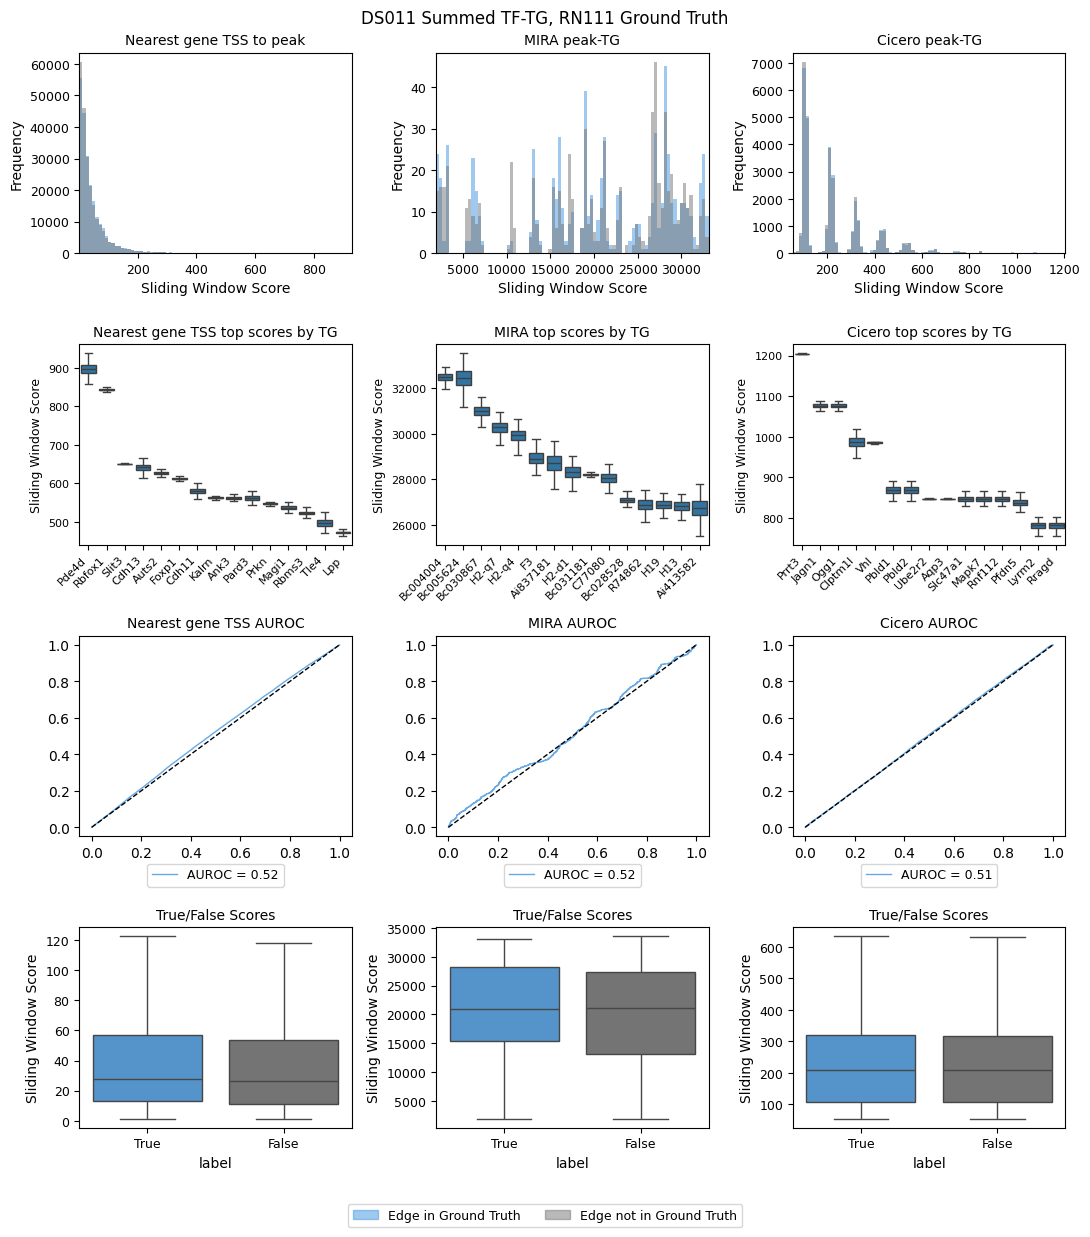

In [15]:
fig = dev_plots.tg_assignment_multiplot(
    nearest_tss_df=ds011_gene_tss_tf_tg_sum_rn111_df,
    mira_df=ds011_mira_tf_tg_sum_rn111_df,
    cicero_df=ds011_cicero_tf_tg_sum_rn111_df,
    suptitle="DS011 Summed TF-TG, RN111 Ground Truth"
)

#### Label edges using RN115

In [16]:
ds011_gene_tss_tf_tg_sum_rn115_df = merge_dataset_with_ground_truth(
    ds011_gene_tss_tf_tg_sum_df, rn115_ko_ground_truth,
    method="nearest gene TSS", gt_name="RN115"
    )
ds011_mira_tf_tg_sum_rn115_df = merge_dataset_with_ground_truth(
    ds011_mira_tf_tg_sum_df, rn115_ko_ground_truth,
    method="MIRA", gt_name="RN115"
    )
ds011_cicero_tf_tg_sum_rn115_df = merge_dataset_with_ground_truth(
    ds011_cicero_tf_tg_sum_df, rn115_ko_ground_truth,
    method="Cicero", gt_name="RN115"
    )

In [17]:
ds011_gene_tss_tf_tg_sum_rn115_df.to_parquet(os.path.join(cache_folder, "ds011_gene_tss_tf_tg_sum_rn115_df.parquet"))
ds011_mira_tf_tg_sum_rn115_df.to_parquet(os.path.join(cache_folder, "ds011_mira_tf_tg_sum_rn115_df.parquet"))
ds011_cicero_tf_tg_sum_rn115_df.to_parquet(os.path.join(cache_folder, "ds011_cicero_tf_tg_sum_rn115_df.parquet"))

In [18]:
ds011_gene_tss_tf_tg_sum_rn115_df = pd.read_parquet(os.path.join(cache_folder, "ds011_gene_tss_tf_tg_sum_rn115_df.parquet"))
ds011_mira_tf_tg_sum_rn115_df = pd.read_parquet(os.path.join(cache_folder, "ds011_mira_tf_tg_sum_rn115_df.parquet"))
ds011_cicero_tf_tg_sum_rn115_df = pd.read_parquet(os.path.join(cache_folder, "ds011_cicero_tf_tg_sum_rn115_df.parquet"))

/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)
/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)
/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)


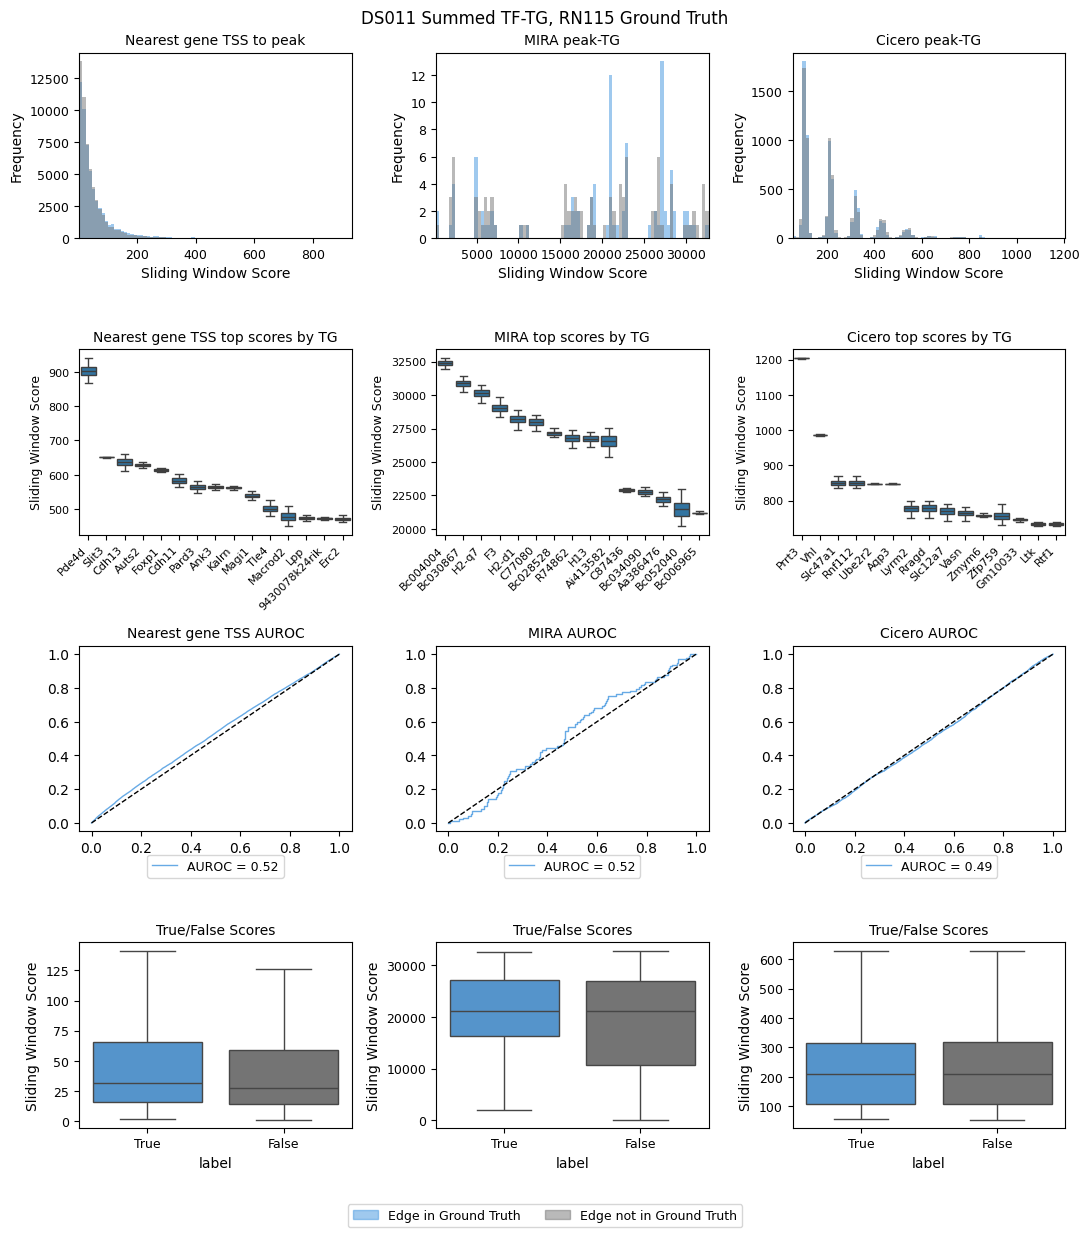

In [19]:
fig = dev_plots.tg_assignment_multiplot(
    nearest_tss_df=ds011_gene_tss_tf_tg_sum_rn115_df,
    mira_df=ds011_mira_tf_tg_sum_rn115_df,
    cicero_df=ds011_cicero_tf_tg_sum_rn115_df,
    suptitle="DS011 Summed TF-TG, RN115 Ground Truth"
)

---

### Evaluating individual TF-peak-TG scores

Next, we evaluate the sliding window scores calculated using Method 2, which does not sum all of the peaks for each TF-TG edge, but instead keeps each TF-peak-TG edge as a separate score:

$$\text{Sliding Window Score}_{\text{TF-peak-TG}} = \frac{\text{sliding window score}_{\text{TF-peak-TG}}}{\sum \text{Total sliding window scores}_{\text{TF}}}$$

In [20]:
ds011_gene_tss_tf_peak_tg_df = calculate_tf_peak_tg_score(ds011_gene_tss_sliding_window_df)
ds011_mira_tf_peak_tg_df = calculate_tf_peak_tg_score(ds011_mira_sliding_window_df)
ds011_cicero_tf_peak_tg_df = calculate_tf_peak_tg_score(ds011_cicero_sliding_window_df)

#### Label edges using RN111

In [21]:
ds011_gene_tss_tf_peak_tg_rn111_df = merge_dataset_with_ground_truth(
    ds011_gene_tss_tf_peak_tg_df, rn111_chipseq_ground_truth,
    method="nearest gene TSS", gt_name="RN111"
    )
ds011_mira_tf_peak_tg_rn111_df = merge_dataset_with_ground_truth(
    ds011_mira_tf_peak_tg_df, rn111_chipseq_ground_truth,
    method="MIRA", gt_name="RN111"
    )
ds011_cicero_tf_peak_tg_rn111_df = merge_dataset_with_ground_truth(
    ds011_cicero_tf_peak_tg_df, rn111_chipseq_ground_truth,
    method="Cicero", gt_name="RN111"
    )

In [22]:
ds011_gene_tss_tf_peak_tg_rn111_df.to_parquet(os.path.join(cache_folder, "ds011_gene_tss_tf_peak_tg_rn111_df.parquet"))
ds011_mira_tf_peak_tg_rn111_df.to_parquet(os.path.join(cache_folder, "ds011_mira_tf_peak_tg_rn111_df.parquet"))
ds011_cicero_tf_peak_tg_rn111_df.to_parquet(os.path.join(cache_folder, "ds011_cicero_tf_peak_tg_rn111_df.parquet"))

In [23]:
ds011_gene_tss_tf_peak_tg_rn111_df = pd.read_parquet(os.path.join(cache_folder, "ds011_gene_tss_tf_peak_tg_rn111_df.parquet"))
ds011_mira_tf_peak_tg_rn111_df = pd.read_parquet(os.path.join(cache_folder, "ds011_mira_tf_peak_tg_rn111_df.parquet"))
ds011_cicero_tf_peak_tg_rn111_df = pd.read_parquet(os.path.join(cache_folder, "ds011_cicero_tf_peak_tg_rn111_df.parquet"))

/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)
/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)
/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)


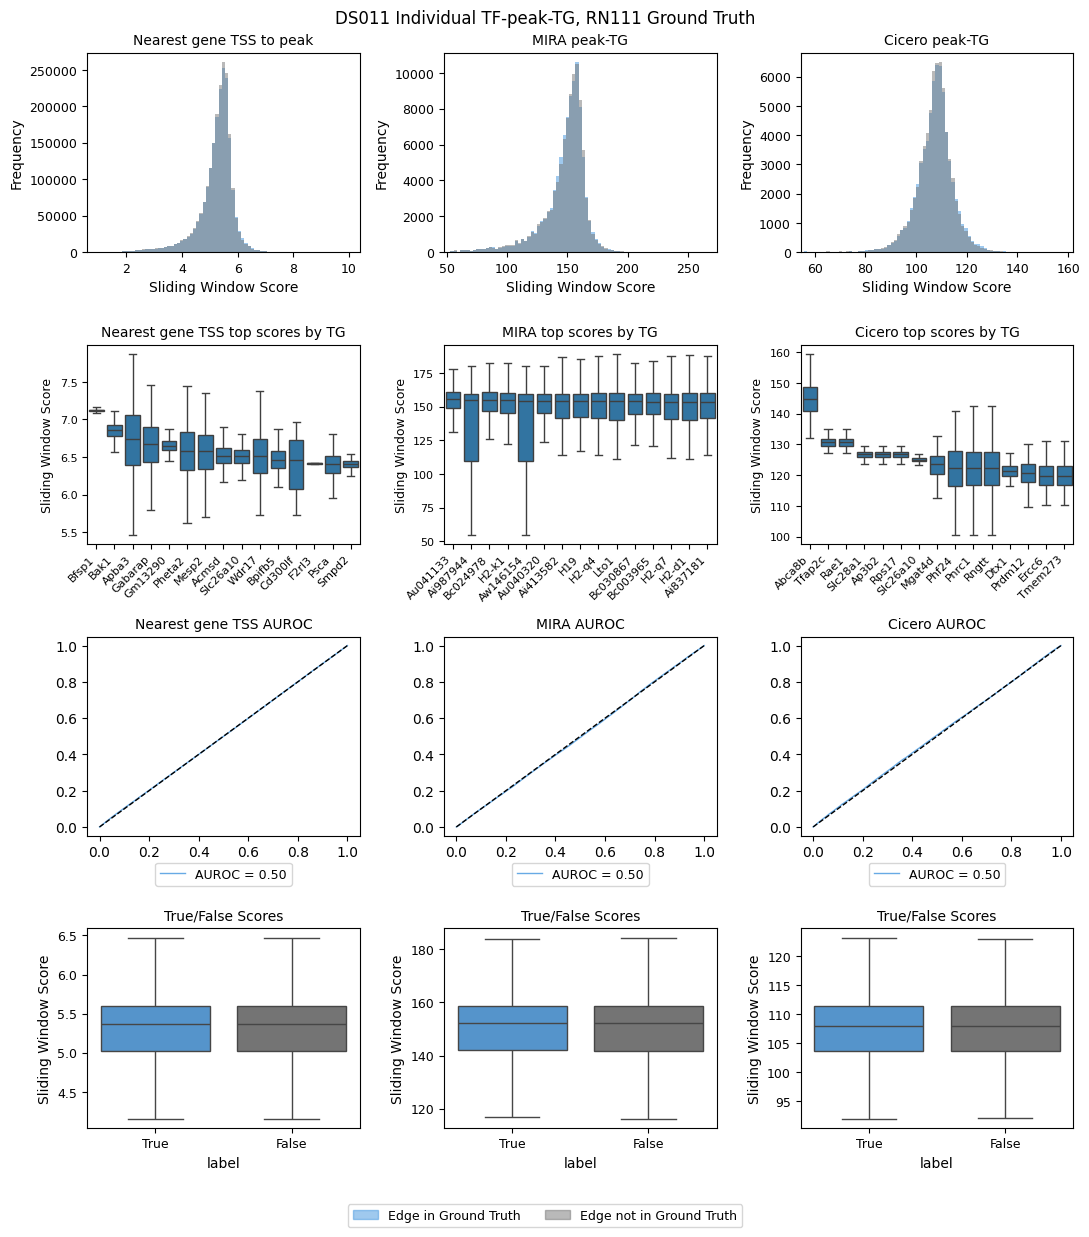

In [24]:
fig = dev_plots.tg_assignment_multiplot(
    nearest_tss_df=ds011_gene_tss_tf_peak_tg_rn111_df,
    mira_df=ds011_mira_tf_peak_tg_rn111_df,
    cicero_df=ds011_cicero_tf_peak_tg_rn111_df,
    suptitle="DS011 Individual TF-peak-TG, RN111 Ground Truth"
)

#### Label edges using RN115

In [25]:
ds011_gene_tss_tf_peak_tg_rn115_df = merge_dataset_with_ground_truth(
    ds011_gene_tss_tf_peak_tg_df, rn115_ko_ground_truth,
    method="nearest gene TSS", gt_name="RN115"
    )
ds011_mira_tf_peak_tg_rn115_df = merge_dataset_with_ground_truth(
    ds011_mira_tf_peak_tg_df, rn115_ko_ground_truth,
    method="MIRA", gt_name="RN115"
    )
ds011_cicero_tf_peak_tg_rn115_df = merge_dataset_with_ground_truth(
    ds011_cicero_tf_peak_tg_df, rn115_ko_ground_truth,
    method="Cicero", gt_name="RN115"
    )

In [26]:
ds011_gene_tss_tf_peak_tg_rn115_df.to_parquet(os.path.join(cache_folder, "ds011_gene_tss_tf_peak_tg_rn115_df.parquet"))
ds011_mira_tf_peak_tg_rn115_df.to_parquet(os.path.join(cache_folder, "ds011_mira_tf_peak_tg_rn115_df.parquet"))
ds011_cicero_tf_peak_tg_rn115_df.to_parquet(os.path.join(cache_folder, "ds011_cicero_tf_peak_tg_rn115_df.parquet"))

In [27]:
ds011_gene_tss_tf_peak_tg_rn115_df = pd.read_parquet(os.path.join(cache_folder, "ds011_gene_tss_tf_peak_tg_rn115_df.parquet"))
ds011_mira_tf_peak_tg_rn115_df = pd.read_parquet(os.path.join(cache_folder, "ds011_mira_tf_peak_tg_rn115_df.parquet"))
ds011_cicero_tf_peak_tg_rn115_df = pd.read_parquet(os.path.join(cache_folder, "ds011_cicero_tf_peak_tg_rn115_df.parquet"))

/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)
/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)
/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)


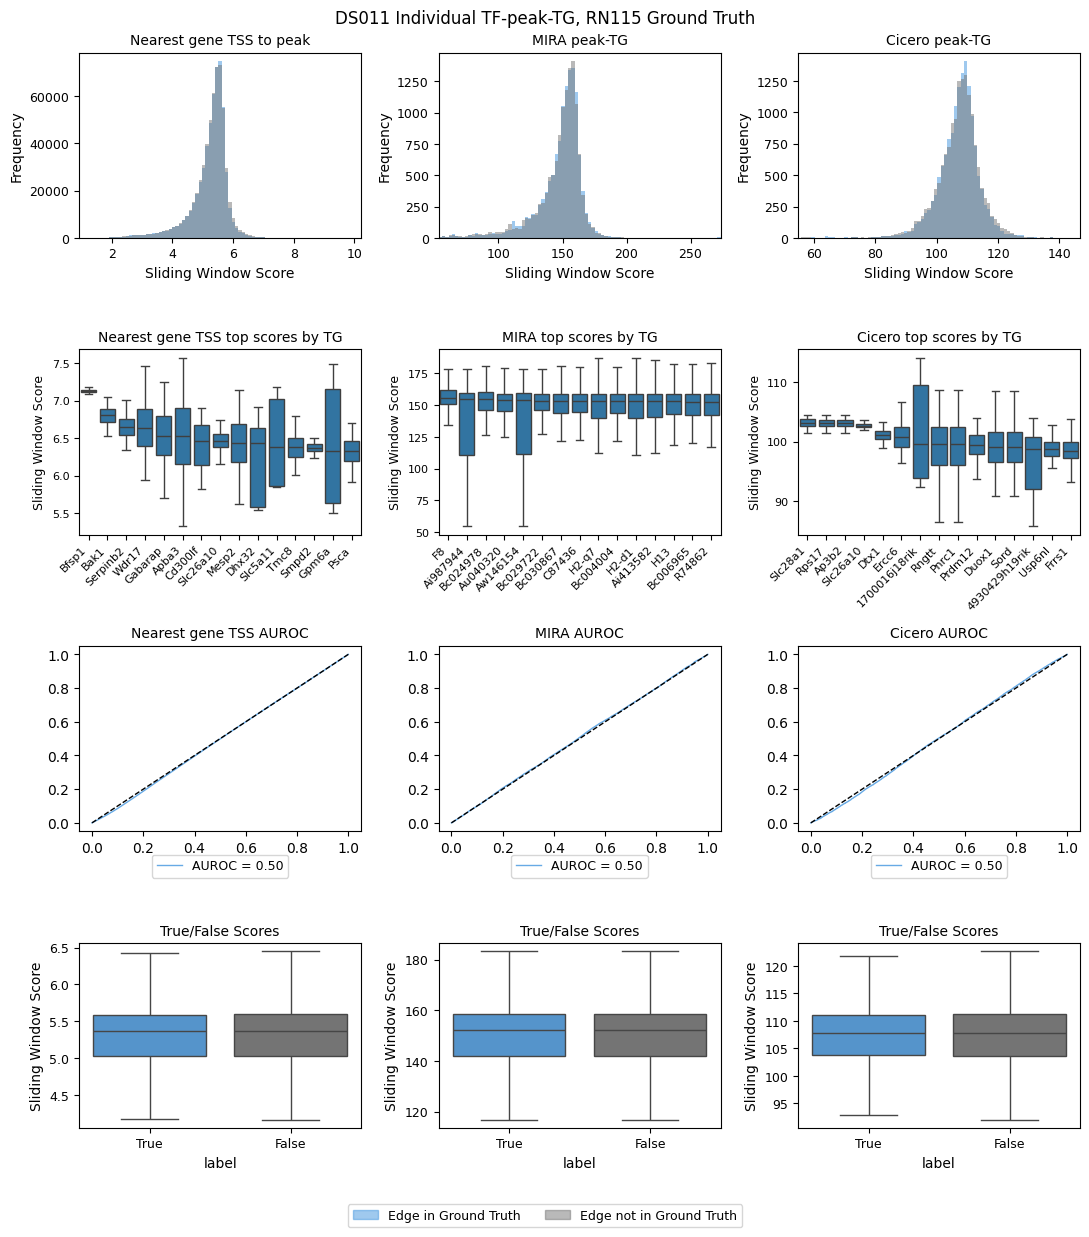

In [28]:
fig = dev_plots.tg_assignment_multiplot(
    nearest_tss_df=ds011_gene_tss_tf_peak_tg_rn115_df,
    mira_df=ds011_mira_tf_peak_tg_rn115_df,
    cicero_df=ds011_cicero_tf_peak_tg_rn115_df,
    suptitle="DS011 Individual TF-peak-TG, RN115 Ground Truth"
)

---

## mESC Filtered L2 E7.5 Rep1

We first need to read in the sliding window scores, peak to gene distances, MIRA peak-TG scores, and the Cicero peak-TG scores for the mESC filtered L2 E7.5 Rep1 dataset.

### Reading in the peak-TG score files

In [29]:
mesc_output_dir = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/output/mESC/filtered_L2_E7.5_rep1"
mesc_sliding_window_df = pd.read_parquet(os.path.join(mesc_output_dir, "no_norm_sliding_window_tf_to_peak_score.parquet"), engine="pyarrow")

mesc_peak_to_gene_distance_file = os.path.join(mesc_output_dir, "tmp/peak_to_gene_map.parquet")
mesc_mira_df = pd.read_parquet("/gpfs/Home/esm5360/MIRA/mira-datasets/mESC_filtered_L2_E7.5_rep1/mESC_E7.5_rep1_mira_peak_to_tg_scores_nonzero.parquet", engine="pyarrow")
mesc_cicero_peak_to_tg_df = pd.read_parquet(os.path.join(mesc_output_dir, "cicero_peak_to_tg_scores.parquet"), engine="pyarrow")

### Setting the TGs for the TF-peak edges using closest TSS, MIRA, or Cicero

In [30]:
mesc_gene_tss_sliding_window_df = set_tg_as_closest_gene_tss(mesc_sliding_window_df, mesc_peak_to_gene_distance_file)
mesc_mira_sliding_window_df = set_tg_using_mira_peak_tg_edges(mesc_sliding_window_df, mesc_mira_df)
mesc_cicero_sliding_window_df = set_tg_using_cicero_peak_tg_edges(mesc_sliding_window_df, mesc_cicero_peak_to_tg_df)

### Evaluating summed TF-TG scores

In [31]:
mesc_gene_tss_tf_tg_sum_df = calculate_summed_tf_tg_score(mesc_gene_tss_sliding_window_df)
mesc_mira_tf_tg_sum_df = calculate_summed_tf_tg_score(mesc_mira_sliding_window_df)
mesc_cicero_tf_tg_sum_df = calculate_summed_tf_tg_score(mesc_cicero_sliding_window_df)

#### Label edges using RN111

In [32]:
mesc_gene_tss_tf_tg_sum_rn111_df = merge_dataset_with_ground_truth(
    mesc_gene_tss_tf_tg_sum_df, rn111_chipseq_ground_truth,
    method="nearest gene TSS", gt_name="RN111"
    )
mesc_mira_tf_tg_sum_rn111_df = merge_dataset_with_ground_truth(
    mesc_mira_tf_tg_sum_df, rn111_chipseq_ground_truth,
    method="MIRA", gt_name="RN111"
    )
mesc_cicero_tf_tg_sum_rn111_df = merge_dataset_with_ground_truth(
    mesc_cicero_tf_tg_sum_df, rn111_chipseq_ground_truth,
    method="Cicero", gt_name="RN111"
    )

In [33]:
mesc_gene_tss_tf_tg_sum_rn111_df.to_parquet(os.path.join(cache_folder, "mesc_gene_tss_tf_tg_sum_rn111_df.parquet"))
mesc_mira_tf_tg_sum_rn111_df.to_parquet(os.path.join(cache_folder, "mesc_mira_tf_tg_sum_rn111_df.parquet"))
mesc_cicero_tf_tg_sum_rn111_df.to_parquet(os.path.join(cache_folder, "mesc_cicero_tf_tg_sum_rn111_df.parquet"))

In [34]:
mesc_gene_tss_tf_tg_sum_rn111_df = pd.read_parquet(os.path.join(cache_folder, "mesc_gene_tss_tf_tg_sum_rn111_df.parquet"))
mesc_mira_tf_tg_sum_rn111_df = pd.read_parquet(os.path.join(cache_folder, "mesc_mira_tf_tg_sum_rn111_df.parquet"))
mesc_cicero_tf_tg_sum_rn111_df = pd.read_parquet(os.path.join(cache_folder, "mesc_cicero_tf_tg_sum_rn111_df.parquet"))

/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)
/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)
/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)


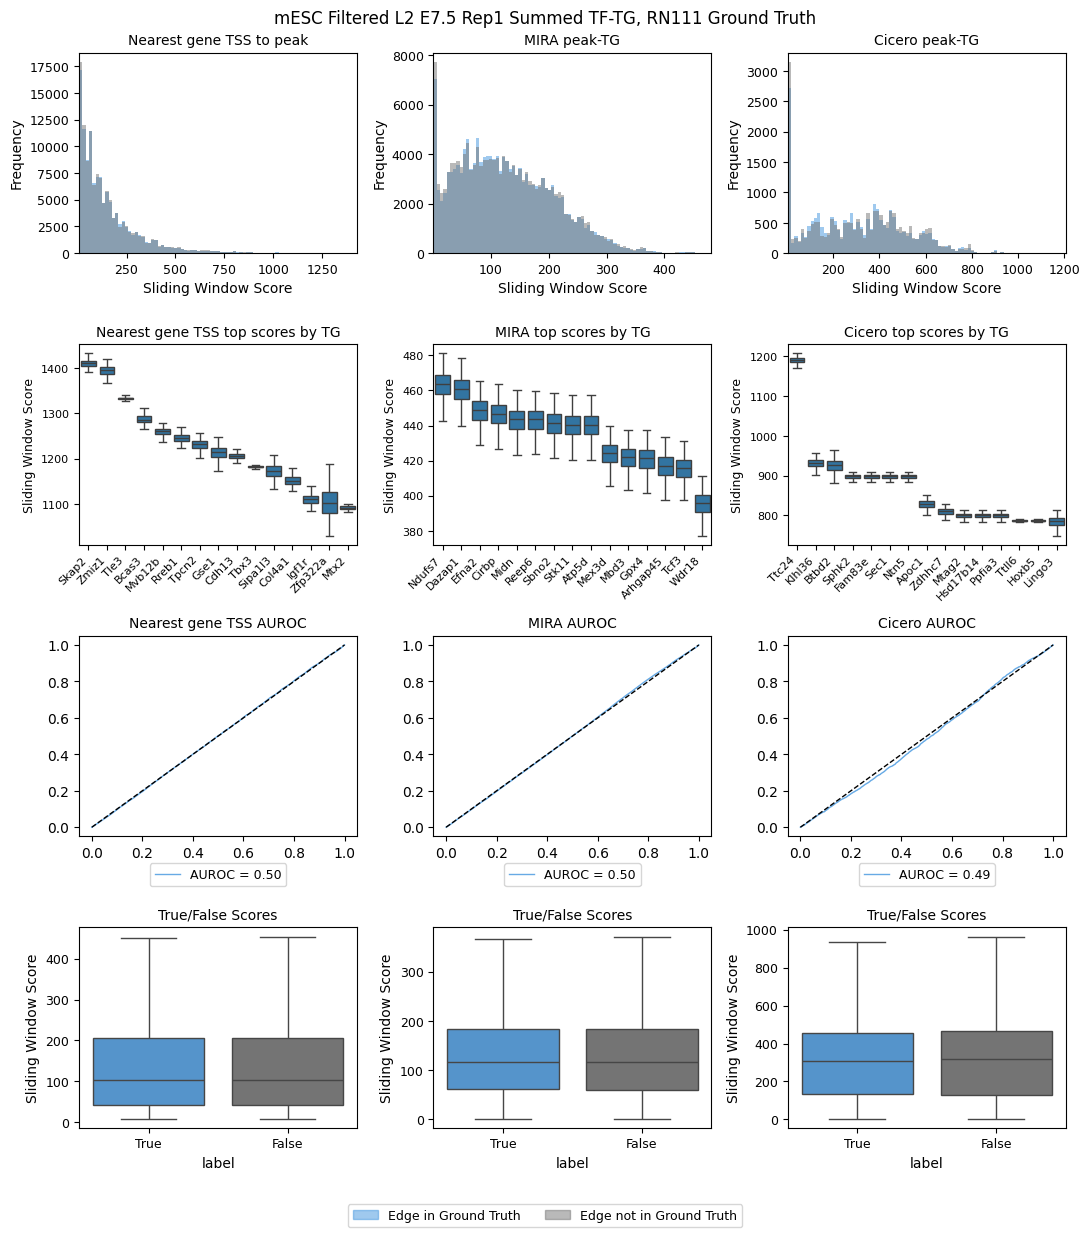

In [35]:
fig = dev_plots.tg_assignment_multiplot(
    nearest_tss_df=mesc_gene_tss_tf_tg_sum_rn111_df,
    mira_df=mesc_mira_tf_tg_sum_rn111_df,
    cicero_df=mesc_cicero_tf_tg_sum_rn111_df,
    suptitle="mESC Filtered L2 E7.5 Rep1 Summed TF-TG, RN111 Ground Truth"
)

#### Label edges using RN115

In [36]:
mesc_gene_tss_tf_tg_sum_rn115_df = merge_dataset_with_ground_truth(
    mesc_gene_tss_tf_tg_sum_df, rn115_ko_ground_truth,
    method="nearest gene TSS", gt_name="RN115"
    )
mesc_mira_tf_tg_sum_rn115_df = merge_dataset_with_ground_truth(
    mesc_mira_tf_tg_sum_df, rn115_ko_ground_truth,
    method="MIRA", gt_name="RN115"
    )
mesc_cicero_tf_tg_sum_rn115_df = merge_dataset_with_ground_truth(
    mesc_cicero_tf_tg_sum_df, rn115_ko_ground_truth,
    method="Cicero", gt_name="RN115"
    )

In [37]:
mesc_gene_tss_tf_tg_sum_rn115_df.to_parquet(os.path.join(cache_folder, "mesc_gene_tss_tf_tg_sum_rn115_df.parquet"))
mesc_mira_tf_tg_sum_rn115_df.to_parquet(os.path.join(cache_folder, "mesc_mira_tf_tg_sum_rn115_df.parquet"))
mesc_cicero_tf_tg_sum_rn115_df.to_parquet(os.path.join(cache_folder, "mesc_cicero_tf_tg_sum_rn115_df.parquet"))

In [38]:
mesc_gene_tss_tf_tg_sum_rn115_df = pd.read_parquet(os.path.join(cache_folder, "mesc_gene_tss_tf_tg_sum_rn115_df.parquet"))
mesc_mira_tf_tg_sum_rn115_df = pd.read_parquet(os.path.join(cache_folder, "mesc_mira_tf_tg_sum_rn115_df.parquet"))
mesc_cicero_tf_tg_sum_rn115_df = pd.read_parquet(os.path.join(cache_folder, "mesc_cicero_tf_tg_sum_rn115_df.parquet"))

/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)
/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)
/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)


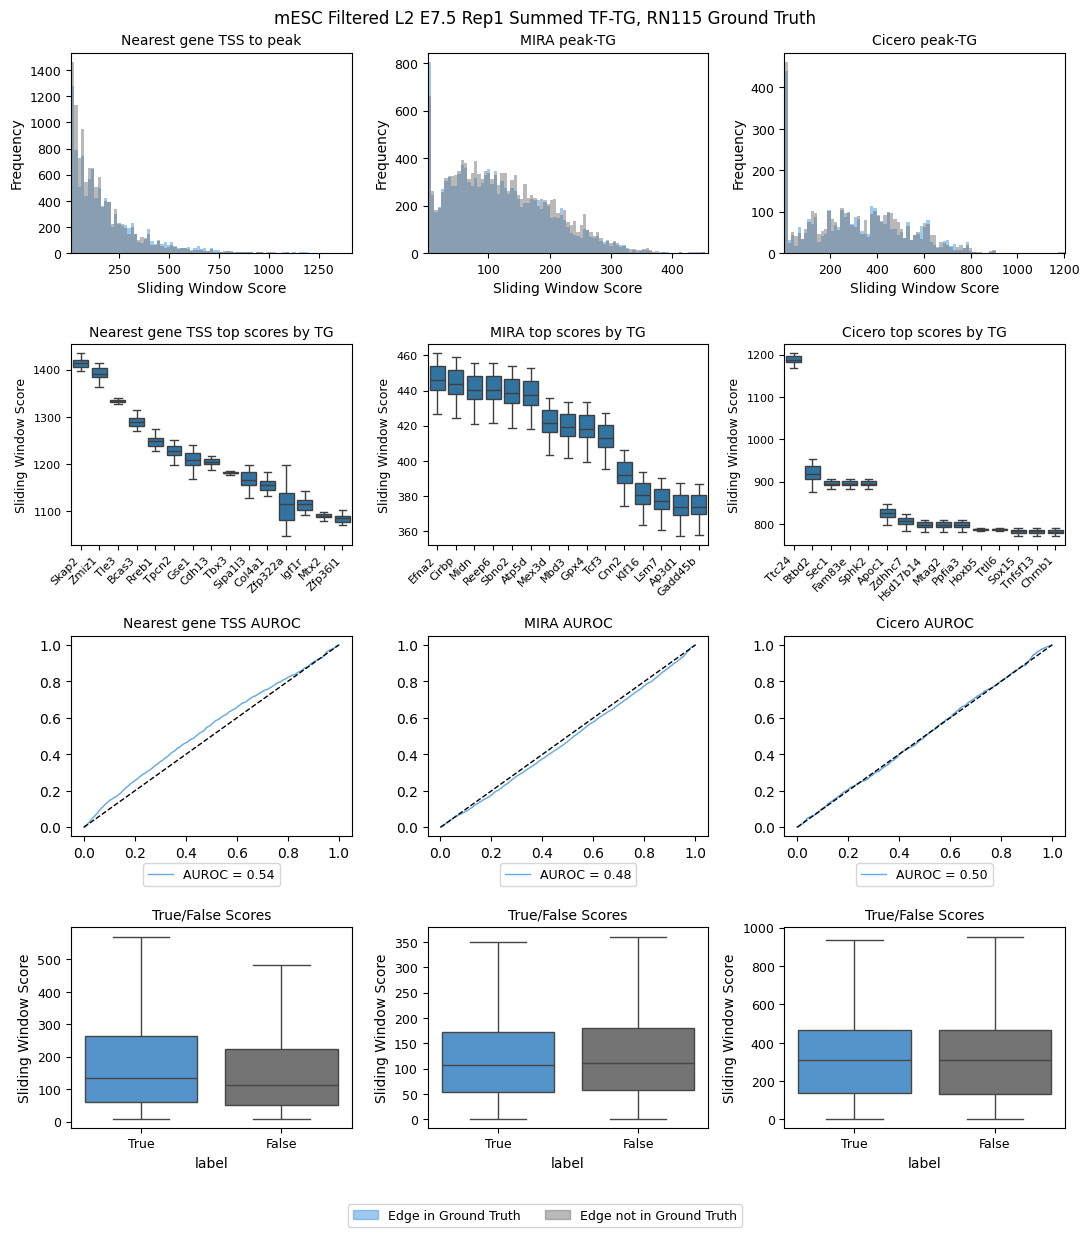

In [39]:
fig = dev_plots.tg_assignment_multiplot(
    nearest_tss_df=mesc_gene_tss_tf_tg_sum_rn115_df,
    mira_df=mesc_mira_tf_tg_sum_rn115_df,
    cicero_df=mesc_cicero_tf_tg_sum_rn115_df,
    suptitle="mESC Filtered L2 E7.5 Rep1 Summed TF-TG, RN115 Ground Truth"
)

### Evaluating individual TF-peak-TG scores

In [40]:
mesc_gene_tss_tf_peak_tg_df = calculate_tf_peak_tg_score(mesc_gene_tss_sliding_window_df)
mesc_mira_tf_peak_tg_df = calculate_tf_peak_tg_score(mesc_mira_sliding_window_df)
mesc_cicero_tf_peak_tg_df = calculate_tf_peak_tg_score(mesc_cicero_sliding_window_df)

#### Label edges using RN111

In [41]:
mesc_gene_tss_tf_peak_tg_rn111_df = merge_dataset_with_ground_truth(
    mesc_gene_tss_tf_peak_tg_df, rn111_chipseq_ground_truth,
    method="nearest gene TSS", gt_name="RN111"
    )
mesc_mira_tf_peak_tg_rn111_df = merge_dataset_with_ground_truth(
    mesc_mira_tf_peak_tg_df, rn111_chipseq_ground_truth,
    method="MIRA", gt_name="RN111"
    )
mesc_cicero_tf_peak_tg_rn111_df = merge_dataset_with_ground_truth(
    mesc_cicero_tf_peak_tg_df, rn111_chipseq_ground_truth,
    method="Cicero", gt_name="RN111"
    )



In [42]:
mesc_gene_tss_tf_peak_tg_rn111_df.to_parquet(os.path.join(cache_folder, "mesc_gene_tss_tf_peak_tg_rn111_df.parquet"))
mesc_mira_tf_peak_tg_rn111_df.to_parquet(os.path.join(cache_folder, "mesc_mira_tf_peak_tg_rn111_df.parquet"))
mesc_cicero_tf_peak_tg_rn111_df.to_parquet(os.path.join(cache_folder, "mesc_cicero_tf_peak_tg_rn111_df.parquet"))

In [43]:
mesc_gene_tss_tf_peak_tg_rn111_df = pd.read_parquet(os.path.join(cache_folder, "mesc_gene_tss_tf_peak_tg_rn111_df.parquet"))
mesc_mira_tf_peak_tg_rn111_df = pd.read_parquet(os.path.join(cache_folder, "mesc_mira_tf_peak_tg_rn111_df.parquet"))
mesc_cicero_tf_peak_tg_rn111_df = pd.read_parquet(os.path.join(cache_folder, "mesc_cicero_tf_peak_tg_rn111_df.parquet"))

/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)
/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)
/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)


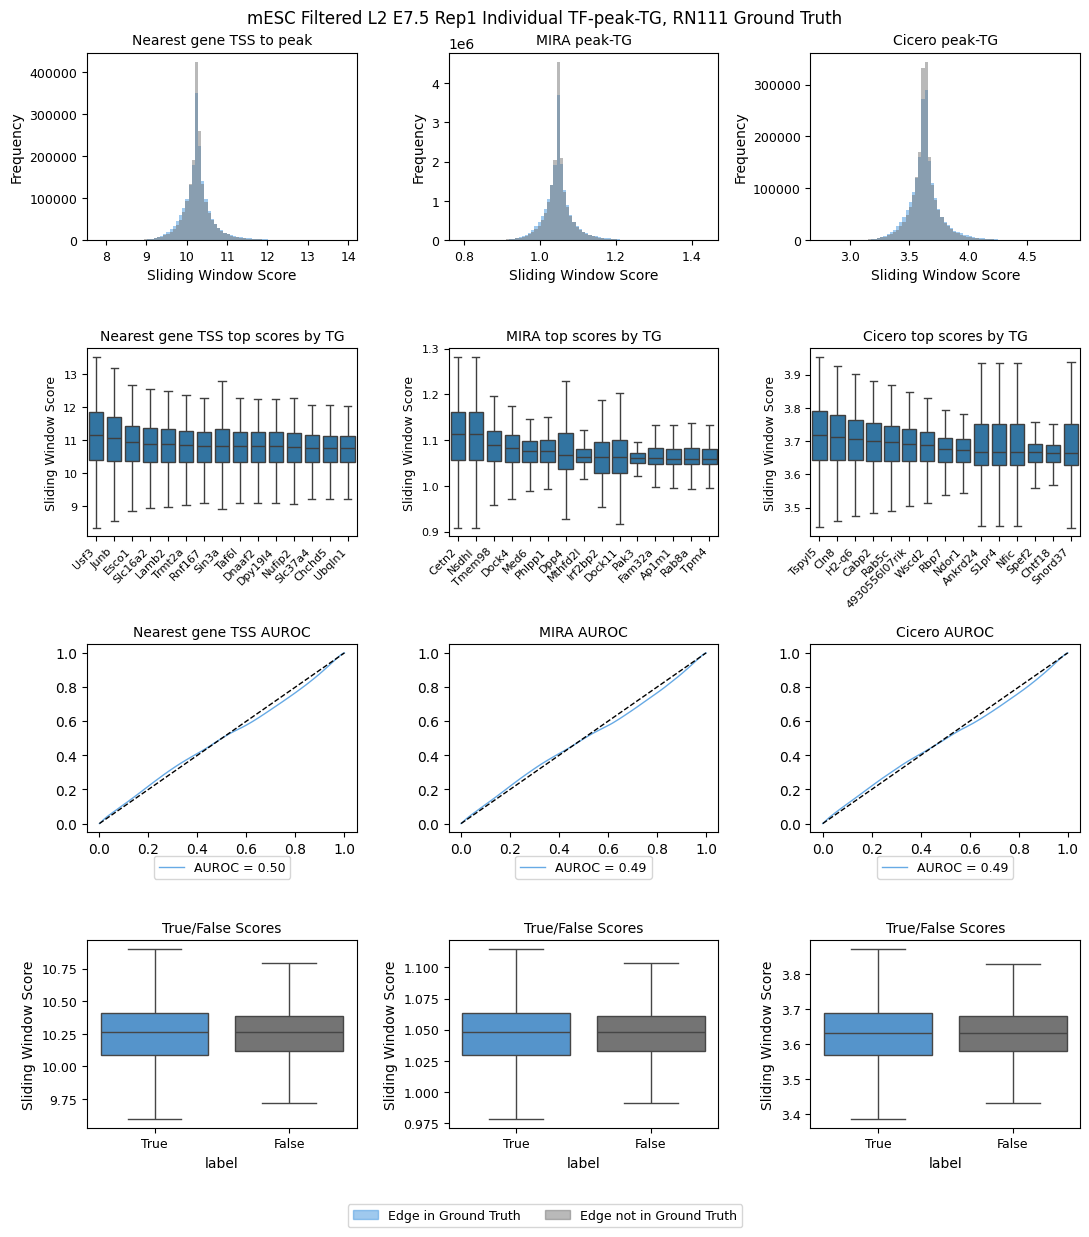

In [44]:
fig = dev_plots.tg_assignment_multiplot(
    nearest_tss_df=mesc_gene_tss_tf_peak_tg_rn111_df,
    mira_df=mesc_mira_tf_peak_tg_rn111_df,
    cicero_df=mesc_cicero_tf_peak_tg_rn111_df,
    suptitle="mESC Filtered L2 E7.5 Rep1 Individual TF-peak-TG, RN111 Ground Truth"
)

#### Label edges using RN115

In [45]:
mesc_gene_tss_tf_peak_tg_rn115_df = merge_dataset_with_ground_truth(
    mesc_gene_tss_tf_peak_tg_df, rn115_ko_ground_truth,
    method="nearest gene TSS", gt_name="RN115"
    )
mesc_mira_tf_peak_tg_rn115_df = merge_dataset_with_ground_truth(
    mesc_mira_tf_peak_tg_df, rn115_ko_ground_truth,
    method="MIRA", gt_name="RN115"
    )
mesc_cicero_tf_peak_tg_rn115_df = merge_dataset_with_ground_truth(
    mesc_cicero_tf_peak_tg_df, rn115_ko_ground_truth,
    method="Cicero", gt_name="RN115"
    )

In [46]:
mesc_gene_tss_tf_peak_tg_rn115_df.to_parquet(os.path.join(cache_folder, "mesc_gene_tss_tf_peak_tg_rn115_df.parquet"))
mesc_mira_tf_peak_tg_rn115_df.to_parquet(os.path.join(cache_folder, "mesc_mira_tf_peak_tg_rn115_df.parquet"))
mesc_cicero_tf_peak_tg_rn115_df.to_parquet(os.path.join(cache_folder, "mesc_cicero_tf_peak_tg_rn115_df.parquet"))

In [47]:
mesc_gene_tss_tf_peak_tg_rn115_df = pd.read_parquet(os.path.join(cache_folder, "mesc_gene_tss_tf_peak_tg_rn115_df.parquet"))
mesc_mira_tf_peak_tg_rn115_df = pd.read_parquet(os.path.join(cache_folder, "mesc_mira_tf_peak_tg_rn115_df.parquet"))
mesc_cicero_tf_peak_tg_rn115_df = pd.read_parquet(os.path.join(cache_folder, "mesc_cicero_tf_peak_tg_rn115_df.parquet"))

/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)
/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)
/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)


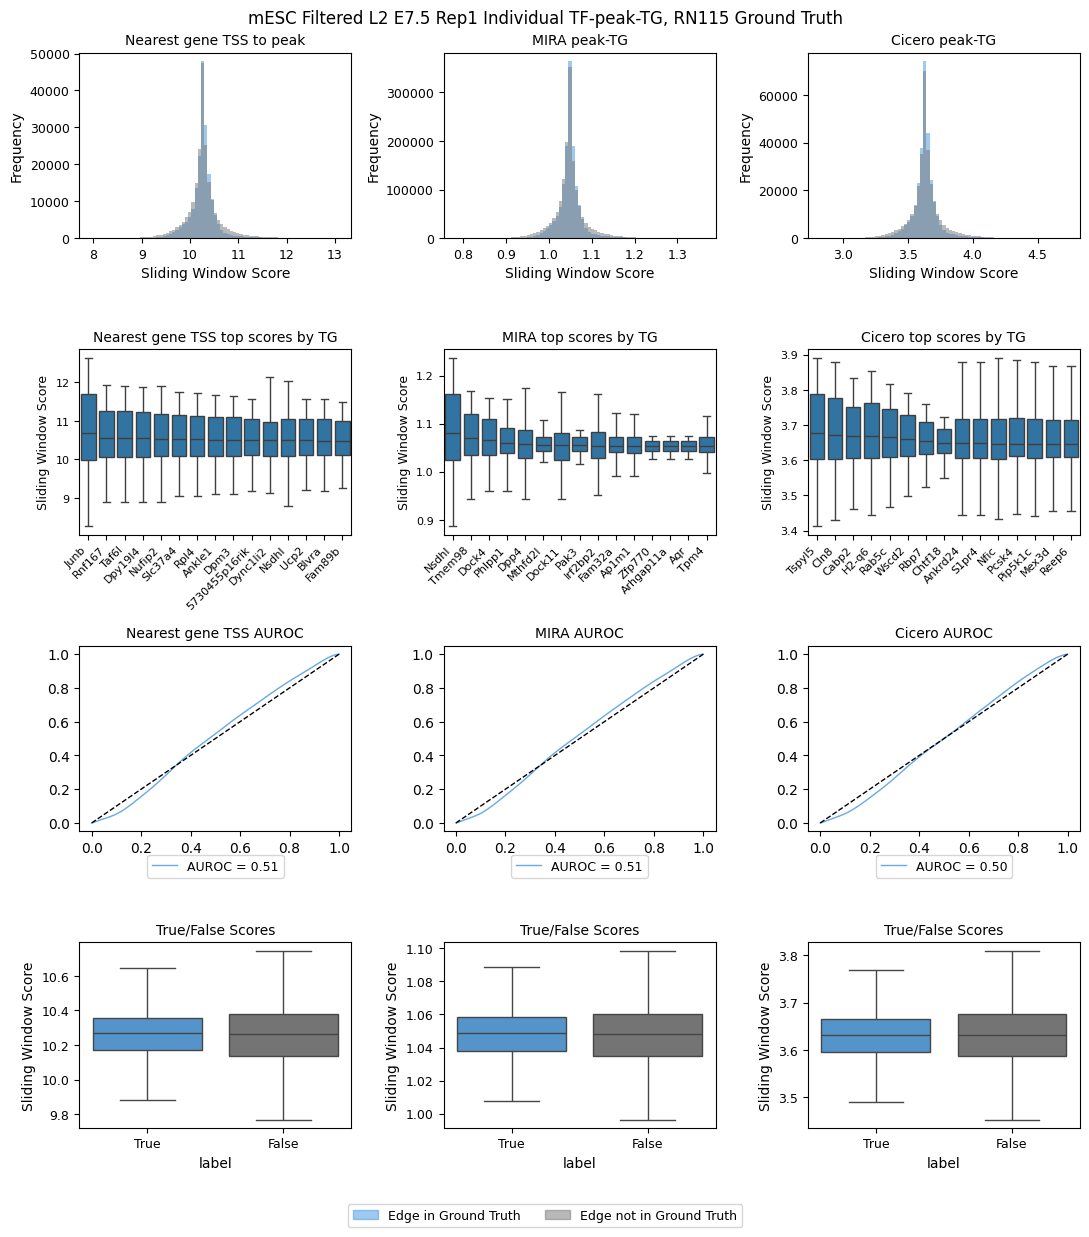

In [48]:
fig = dev_plots.tg_assignment_multiplot(
    nearest_tss_df=mesc_gene_tss_tf_peak_tg_rn115_df,
    mira_df=mesc_mira_tf_peak_tg_rn115_df,
    cicero_df=mesc_cicero_tf_peak_tg_rn115_df,
    suptitle="mESC Filtered L2 E7.5 Rep1 Individual TF-peak-TG, RN115 Ground Truth"
)

---

## ChIP-seq

As a control, we want to test how well the sliding window score method works for ChIP-seq datasets, where we know the TF-peak binding. We used a ChIP-seq dataset where the mouse embryonic data from ChIP-Atlas was merged with the RN111 BEELINE ChIP-seq dataset along shared edges. See `chipseq_sliding_window.ipynb` for the process used. We will only be able to evaluate mapping TGs using the nearest gene TSS method.

### Reading in the peak-TG score files

In [40]:
chipseq_output_dir = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/output/chipseq_sliding_window"
chipseq_sliding_window_df = pd.read_parquet(os.path.join(chipseq_output_dir, "no_norm_sliding_window_tf_to_peak_score.parquet"), engine="pyarrow")

### Setting TGs as closest gene TSS, score calculations, merging with ground truth

In [53]:
chipseq_peak_to_gene_distance_file = os.path.join(chipseq_output_dir, "tss_distance_score.parquet")

tss_distances = pd.read_parquet(os.path.join(chipseq_output_dir, "tss_distance_score.parquet"))
closest_gene_to_peak_df = tss_distances.sort_values("TSS_dist_score", ascending=False).groupby("peak_id").first()
closest_gene_to_peak_df = closest_gene_to_peak_df[["target_id"]].reset_index()
chipseq_gene_tss_sliding_window_df = pd.merge(chipseq_sliding_window_df, closest_gene_to_peak_df, on="peak_id", how="inner")


chipseq_gene_tss_tf_tg_sum_df = calculate_summed_tf_tg_score(chipseq_gene_tss_sliding_window_df)
chipseq_gene_tss_tf_peak_tg_df = calculate_tf_peak_tg_score(chipseq_gene_tss_sliding_window_df)

chipseq_gene_tss_tf_tg_sum_rn111_df = merge_dataset_with_ground_truth(
    chipseq_gene_tss_tf_tg_sum_df, rn111_chipseq_ground_truth,
    method="nearest gene TSS", gt_name="RN111"
    )

chipseq_gene_tss_tf_tg_sum_rn115_df = merge_dataset_with_ground_truth(
    chipseq_gene_tss_tf_tg_sum_df, rn115_ko_ground_truth,
    method="nearest gene TSS", gt_name="RN115"
    )

chipseq_gene_tss_tf_peak_tg_rn111_df = merge_dataset_with_ground_truth(
    chipseq_gene_tss_tf_peak_tg_df, rn111_chipseq_ground_truth,
    method="nearest gene TSS", gt_name="RN111"
    )

chipseq_gene_tss_tf_peak_tg_rn115_df = merge_dataset_with_ground_truth(
    chipseq_gene_tss_tf_peak_tg_df, rn115_ko_ground_truth,
    method="nearest gene TSS", gt_name="RN115"
    )

In [54]:
chipseq_gene_tss_tf_tg_sum_rn111_df.to_parquet(f"{cache_folder}/chipseq_gene_tss_tf_tg_sum_rn111_df.parquet")
chipseq_gene_tss_tf_tg_sum_rn115_df.to_parquet(f"{cache_folder}/chipseq_gene_tss_tf_tg_sum_rn115_df.parquet")
chipseq_gene_tss_tf_peak_tg_rn111_df.to_parquet(f"{cache_folder}/chipseq_gene_tss_tf_peak_tg_rn111_df.parquet")
chipseq_gene_tss_tf_peak_tg_rn115_df.to_parquet(f"{cache_folder}/chipseq_gene_tss_tf_peak_tg_rn115_df.parquet")

In [ ]:
chipseq_gene_tss_tf_tg_sum_rn111_df = pd.read_parquet(f"{cache_folder}/chipseq_gene_tss_tf_tg_sum_rn111_df.parquet")
chipseq_gene_tss_tf_tg_sum_rn115_df = pd.read_parquet(f"{cache_folder}/chipseq_gene_tss_tf_tg_sum_rn115_df.parquet")
chipseq_gene_tss_tf_peak_tg_rn111_df = pd.read_parquet(f"{cache_folder}/chipseq_gene_tss_tf_peak_tg_rn111_df.parquet")
chipseq_gene_tss_tf_peak_tg_rn115_df = pd.read_parquet(f"{cache_folder}/chipseq_gene_tss_tf_peak_tg_rn115_df.parquet")

In [20]:
from dev.notebooks import dev_utils


importlib.reload(dev_utils)

<module 'dev.notebooks.dev_utils' from '/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/dev_utils.py'>

In [55]:
chipseq_gene_tss_tf_tg_sum_rn111_df = dev_utils.merge_dataset_with_ground_truth(
    chipseq_gene_tss_tf_tg_sum_df, rn111_chipseq_ground_truth,
    method="nearest gene TSS", gt_name="RN111",
    show_network_size=True
    )

chipseq_gene_tss_tf_peak_tg_rn111_df = dev_utils.merge_dataset_with_ground_truth(
    chipseq_gene_tss_tf_peak_tg_df, rn111_chipseq_ground_truth,
    method="nearest gene TSS", gt_name="RN111",
    show_network_size=True
    )

- **Overlap between nearest gene TSS and RN111 edges**
	- **Both RN111 and nearest gene TSS**
		- TFs: 19
		- TGs: 48
		- TF-TG Edges: 376
	- **Only Nearest gene tss**
		- TFs: 65
		- TGs: 0
		- TF-TG Edges: 702
	- **Only RN111**
		- TFs: 225
		- TGs: 25,651
		- Edges: 0
- **Overlap between nearest gene TSS and RN111 edges**
	- **Both RN111 and nearest gene TSS**
		- TFs: 19
		- TGs: 48
		- TF-TG Edges: 376
	- **Only Nearest gene tss**
		- TFs: 65
		- TGs: 0
		- TF-TG Edges: 702
	- **Only RN111**
		- TFs: 225
		- TGs: 25,651
		- Edges: 0


In [56]:
chipseq_gene_tss_tf_peak_tg_df[
    (~chipseq_gene_tss_tf_peak_tg_df["source_id"].isin(rn111_chipseq_ground_truth["source_id"])) &
    (~chipseq_gene_tss_tf_peak_tg_df["target_id"].isin(rn111_chipseq_ground_truth["target_id"]))  
]

,source_id,peak_id,target_id,sliding_window_score


In [51]:
importlib.reload(dev_plots)

<module 'dev.notebooks.plotting' from '/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py'>

/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)
/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:574: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)


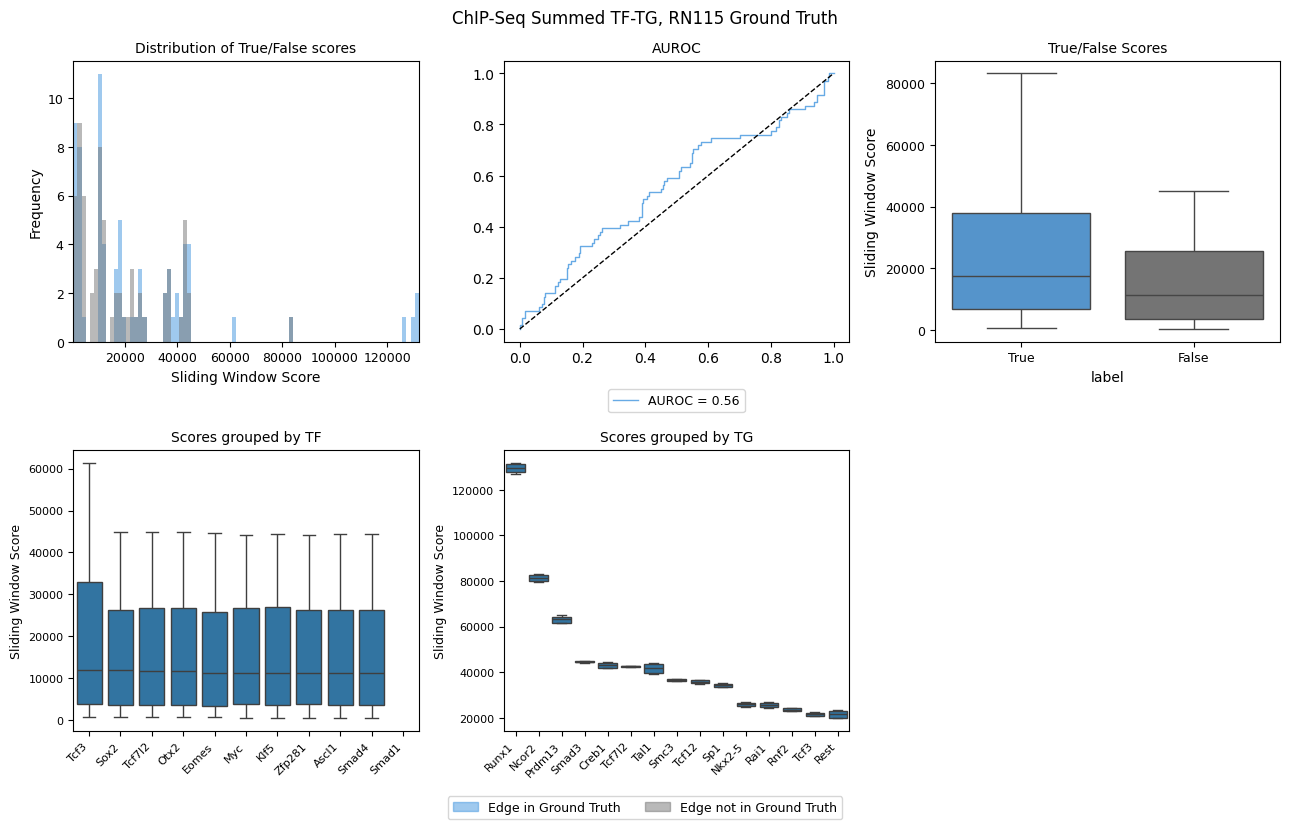

In [67]:
import matplotlib.patches as mpatches
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(13, 8))

chipseq_plot_df = chipseq_gene_tss_tf_tg_sum_rn115_df

dev_plots.plot_scores_distribution(chipseq_plot_df,
                        title="Distribution of True/False scores",
                        ax=axes[0, 0])

dev_plots.plot_grouped_score_boxplot(
    chipseq_plot_df,
    group_col="source_id",
    score_col="sliding_window_score",
    title=f"Scores grouped by TF",
    ylabel="Sliding Window Score",
    n_top_groups=15,
    ax=axes[1, 0]
    )

dev_plots.plot_grouped_score_boxplot(
    chipseq_plot_df,
    group_col="target_id",
    score_col="sliding_window_score",
    title=f"Scores grouped by TG",
    ylabel="Sliding Window Score",
    n_top_groups=15,
    ax=axes[1, 1]
    )


dev_plots.plot_auroc(chipseq_plot_df,
                    score_col="sliding_window_score",
                    title="AUROC",
                    ax=axes[0, 1])

dev_plots.plot_true_false_boxplots(chipseq_plot_df,
                                   ax=axes[0, 2])

fig.delaxes(axes[1, 2])

legend_handles = [
    mpatches.Patch(color="#4195df", alpha=0.5, label="Edge in Ground Truth"),
    mpatches.Patch(color="#747474", alpha=0.5, label="Edge not in Ground Truth")
]
fig.legend(handles=legend_handles,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.04),  # centered below plots
        ncol=2,
        fontsize=9)

plt.suptitle("ChIP-Seq Summed TF-TG, RN115 Ground Truth")

plt.tight_layout()

/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:408: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(bbox_to_anchor=(1.03, 0.5), loc='upper left', borderaxespad=0., fontsize=fontsize-2)


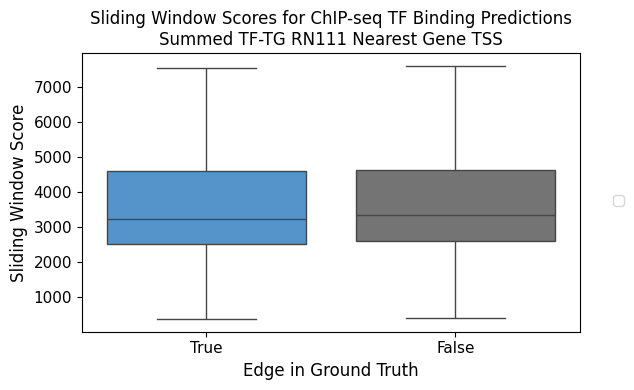

In [58]:
fig = dev_plots.plot_true_false_boxplots(
    df=chipseq_plot_df,
    xlabel="Edge in Ground Truth",
    title="Sliding Window Scores for ChIP-seq TF Binding Predictions\nSummed TF-TG RN111 Nearest Gene TSS"
)
fig.show()

---

## Investivating DS011 Cicero-TG Summation Method Sliding Window Score Distribution

In [ ]:
import numpy as np
mesc_cicero_tf_tg_sum_rn111_df["final_score_no_scaling"] = mesc_cicero_tf_tg_sum_rn111_df["tf_to_tg_peak_scores_summed"].astype(np.float64) / ds011_cicero_tf_tg_sum_rn111_df["total_tf_score"].astype(np.float64)

In [ ]:
ds011_cicero_tf_tg_sum_rn111_df

,source_id,target_id,tf_to_tg_peak_scores_summed,total_tf_score,sliding_window_score,label,final_score_no_scaling
0,Arid3a,0610030e20rik,12934.145419,1.186995e+08,108.965488,False,0.000109
1,Arid3a,0610039k10rik,25626.523497,1.186995e+08,215.894174,False,0.000216
2,Arid3a,0610040j01rik,12922.940587,1.186995e+08,108.871091,False,0.000109
3,Arid3a,1700020a23rik,13835.680367,1.186995e+08,116.560593,False,0.000117
4,Arid3a,1700034e13rik,13933.383886,1.186995e+08,117.383710,False,0.000117
...,...,...,...,...,...,...,...
146320,Zic3,Zp2,23557.565885,2.067197e+08,113.958956,False,0.000114
146321,Zic3,Zranb1,23760.721379,2.067197e+08,114.941715,False,0.000115
146322,Zic3,Zscan20,22268.398221,2.067197e+08,107.722650,False,0.000108
146323,Zic3,Zscan25,87160.728749,2.067197e+08,421.637182,False,0.000422


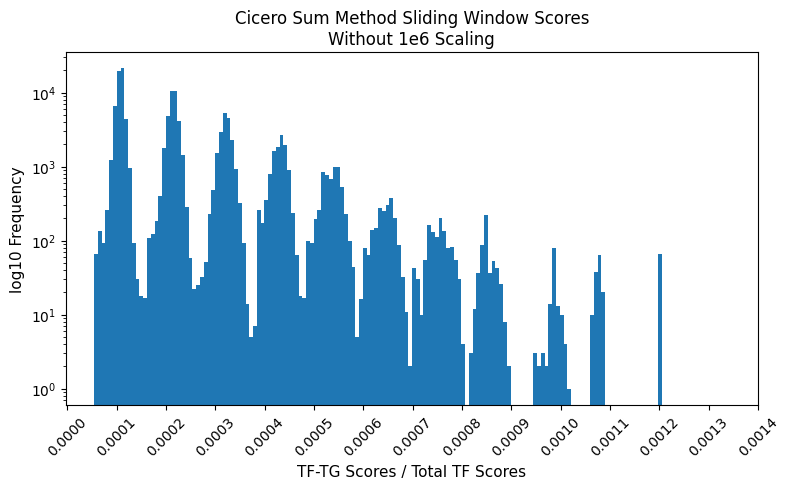

In [ ]:

mask = mesc_cicero_tf_tg_sum_rn111_df["final_score_no_scaling"] > 0.0009

plt.figure(figsize=(8, 5))
plt.hist(ds011_cicero_tf_tg_sum_rn111_df["final_score_no_scaling"], bins=150, log=True)
labels = np.arange(0, 0.0015, 0.0001)
plt.xticks(labels, rotation=45)
plt.title("Cicero Sum Method Sliding Window Scores\nWithout 1e6 Scaling", fontsize=12)
plt.ylabel("log10 Frequency", fontsize=11)
plt.xlabel("TF-TG Scores / Total TF Scores", fontsize=11)
plt.tight_layout()
plt.show()

Let's look at the distributions that are used to calculate the final sliding window score for the TF-TG peak score summation method. We take the sum of peaks for each unique TF-TG edge and divide it by the sum of all sliding window scores for the TF.

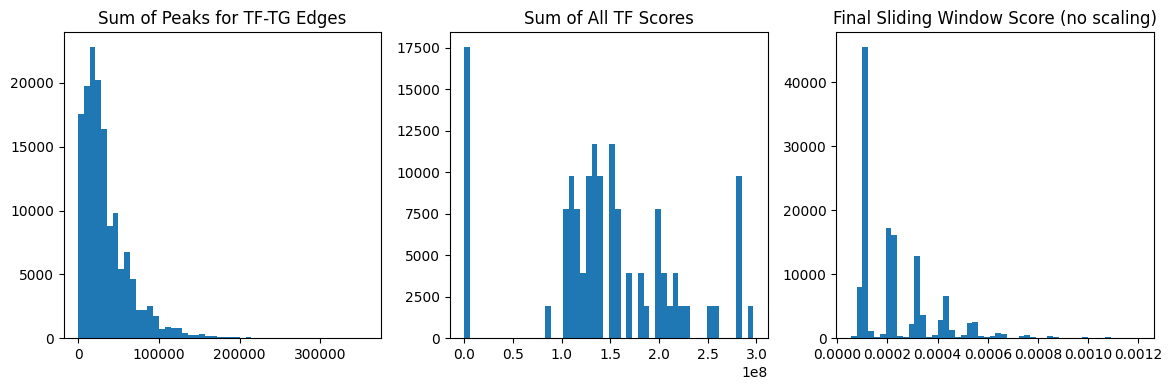

In [ ]:
cols_of_interest = ["tf_to_tg_peak_scores_summed", "total_tf_score", "final_score_no_scaling"]
col_titles = ["Sum of Peaks for TF-TG Edges", "Sum of All TF Scores", "Final Sliding Window Score (no scaling)"]

fig, ax = plt.subplots(1, 3, figsize=(12,4))
for i, ax in enumerate(ax.flat):
    ax.hist(
        ds011_cicero_tf_tg_sum_rn111_df[cols_of_interest[i]],
        bins=50
    )
    ax.set_title(col_titles[i])

plt.tight_layout()
plt.show()

/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:501: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)


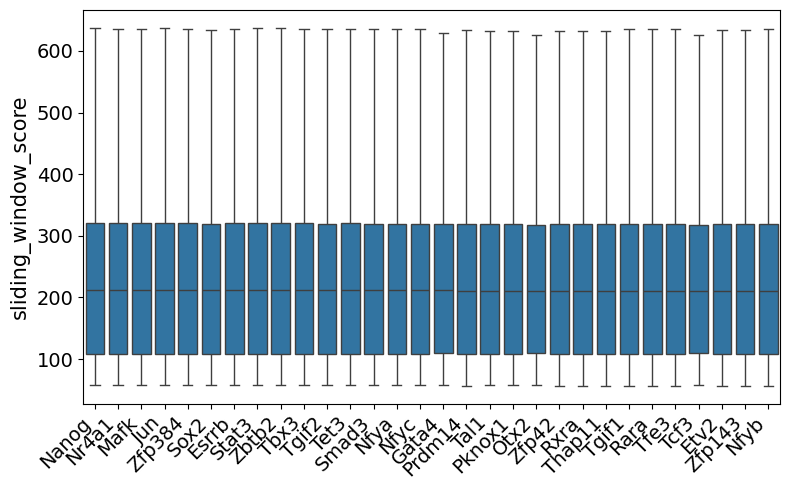

In [ ]:
fig = dev_plots.plot_grouped_score_boxplot(
    df=ds011_cicero_tf_tg_sum_rn111_df,
    group_col="source_id",
    score_col="sliding_window_score",
    n_top_groups=30,
)
fig.show()

In [ ]:
group_by_total_tf_score = (
    ds011_gene_tss_tf_tg_sum_rn111_df[["source_id", "total_tf_score"]]
    .drop_duplicates()
    .set_index("source_id")
    )
group_by_total_tf_score

,total_tf_score
source_id,
Arid3a,2.428686e+09
Ascl1,3.420851e+09
Cdx2,2.275302e+09
Ctcf,3.699613e+09
Ctcfl,4.581302e+09
...,...
Zfp42,2.986780e+09
Zfp57,2.457963e+09
Zfx,5.237529e+09


In [ ]:
grouped_by_tf = (
    ds011_gene_tss_tf_tg_sum_rn111_df
    .groupby("source_id")
    .count()
    .sort_values("total_tf_score", ascending=False)
    ).rename(columns={"target_id":"num_targets"})[["num_targets"]]
grouped_by_tf["total_tf_score"] = grouped_by_tf.index.map(group_by_total_tf_score.squeeze())
grouped_by_tf = grouped_by_tf.sort_values(by="total_tf_score", ascending=False)
max_total_tf_score = max(group_by_total_tf_score["total_tf_score"])
grouped_by_tf["total_tf_score"] = grouped_by_tf["total_tf_score"].apply(lambda x: x / max_total_tf_score)

grouped_by_tf

,num_targets,total_tf_score
source_id,,
Rxra,14728,1.000000
Thap11,14728,0.959771
Zfp143,14728,0.952541
Zfp322a,14728,0.941669
Rest,14728,0.933119
...,...,...
Pou5f1,14728,0.000000
Smad1,14728,0.000000
Setdb1,14728,0.000000


In [ ]:
grouped_by_tg = (
    ds011_gene_tss_tf_tg_sum_rn111_df
    .groupby("target_id")
    .mean(numeric_only=True)
    .sort_values("tf_to_tg_peak_scores_summed", ascending=False)
    ).rename(columns={"tf_to_tg_peak_scores_summed":"mean_tf_to_tg_peak_score"})[["mean_tf_to_tg_peak_score"]]
grouped_by_tg = grouped_by_tg.sort_values(by="mean_tf_to_tg_peak_score", ascending=False)
max_total_tg_score = max(grouped_by_tg["mean_tf_to_tg_peak_score"])
grouped_by_tg["scaled_avg_target_score"] = grouped_by_tg["mean_tf_to_tg_peak_score"].apply(lambda x: x / max_total_tg_score)


grouped_by_tg

,mean_tf_to_tg_peak_score,scaled_avg_target_score
target_id,,
Pde4d,2.481309e+06,1.000000
Rbfox1,2.337633e+06,0.942097
Slit3,1.805125e+06,0.727489
Cdh13,1.782315e+06,0.718296
Auts2,1.734862e+06,0.699172
...,...,...
Rab35,6.620836e+03,0.002668
Trim10,6.256636e+03,0.002522
Taf12,5.719402e+03,0.002305


In [ ]:
first_peak_df = ds011_gene_tss_tf_tg_sum_rn111_df[
    (ds011_gene_tss_tf_tg_sum_rn111_df["sliding_window_score"] >= 60) &
    (ds011_gene_tss_tf_tg_sum_rn111_df["sliding_window_score"] <= 120)
][["source_id", "target_id", "sliding_window_score"]]

second_peak_df = ds011_gene_tss_tf_tg_sum_rn111_df[
    (ds011_gene_tss_tf_tg_sum_rn111_df["sliding_window_score"] >= 180) &
    (ds011_gene_tss_tf_tg_sum_rn111_df["sliding_window_score"] <= 240)
][["source_id", "target_id", "sliding_window_score"]]

third_peak_df = ds011_gene_tss_tf_tg_sum_rn111_df[
    (ds011_gene_tss_tf_tg_sum_rn111_df["sliding_window_score"] >= 300) &
    (ds011_gene_tss_tf_tg_sum_rn111_df["sliding_window_score"] <= 360)
][["source_id", "target_id", "sliding_window_score"]]

fourth_peak_df = ds011_gene_tss_tf_tg_sum_rn111_df[
    (ds011_gene_tss_tf_tg_sum_rn111_df["sliding_window_score"] >= 420) &
    (ds011_gene_tss_tf_tg_sum_rn111_df["sliding_window_score"] <= 480)
][["source_id", "target_id", "sliding_window_score"]]



In [ ]:
first_peak_unique_tfs = first_peak_df[
    (~first_peak_df["source_id"].isin(second_peak_df["source_id"])) &
    (~first_peak_df["source_id"].isin(third_peak_df["source_id"])) &
    (~first_peak_df["source_id"].isin(fourth_peak_df["source_id"]))
    ]
print(f"{len(first_peak_unique_tfs)} / {first_peak_df['source_id'].nunique()} TFs only in the first peak")

second_peak_unique_tfs = second_peak_df[
    (~second_peak_df["source_id"].isin(first_peak_df["source_id"])) &
    (~second_peak_df["source_id"].isin(third_peak_df["source_id"])) &
    (~second_peak_df["source_id"].isin(fourth_peak_df["source_id"]))
    ]
print(f"{len(second_peak_unique_tfs)} / {second_peak_df['source_id'].nunique()} TFs only in the second peak")

third_peak_unique_tfs = third_peak_df[
    (~third_peak_df["source_id"].isin(first_peak_df["source_id"])) &
    (~third_peak_df["source_id"].isin(second_peak_df["source_id"])) &
    (~third_peak_df["source_id"].isin(fourth_peak_df["source_id"]))
    ]
print(f"{len(third_peak_unique_tfs)} / {third_peak_df['source_id'].nunique()} TFs only in the third peak")

fourth_peak_unique_tfs = fourth_peak_df[
    (~fourth_peak_df["source_id"].isin(first_peak_df["source_id"])) &
    (~fourth_peak_df["source_id"].isin(second_peak_df["source_id"])) &
    (~fourth_peak_df["source_id"].isin(third_peak_df["source_id"]))
    ]
print(f"{len(fourth_peak_unique_tfs)} / {fourth_peak_df['source_id'].nunique()} TFs only in the third peak")

0 / 66 TFs only in the first peak
0 / 66 TFs only in the second peak
0 / 66 TFs only in the third peak
0 / 66 TFs only in the third peak


In [ ]:
first_peak_unique_tgs = first_peak_df[
    (~first_peak_df["target_id"].isin(second_peak_df["target_id"])) &
    (~first_peak_df["target_id"].isin(third_peak_df["target_id"])) &
    (~first_peak_df["target_id"].isin(fourth_peak_df["target_id"]))
    ]
print(f"{len(first_peak_unique_tgs)} / {len(first_peak_df)} TGs only in the first peak")

second_peak_unique_tgs = second_peak_df[
    (~second_peak_df["target_id"].isin(first_peak_df["target_id"])) &
    (~second_peak_df["target_id"].isin(third_peak_df["target_id"])) &
    (~second_peak_df["target_id"].isin(fourth_peak_df["target_id"]))
    ]
print(f"{len(second_peak_unique_tgs)} / {len(second_peak_df)} TGs only in the second peak")

third_peak_unique_tgs = third_peak_df[
    (~third_peak_df["target_id"].isin(first_peak_df["target_id"])) &
    (~third_peak_df["target_id"].isin(second_peak_df["target_id"])) &
    (~third_peak_df["target_id"].isin(fourth_peak_df["target_id"]))
    ]
print(f"{len(third_peak_unique_tgs)} / {len(third_peak_df)} TGs only in the third peak")

fourth_peak_unique_tgs = fourth_peak_df[
    (~fourth_peak_df["target_id"].isin(first_peak_df["target_id"])) &
    (~fourth_peak_df["target_id"].isin(second_peak_df["target_id"])) &
    (~fourth_peak_df["target_id"].isin(third_peak_df["target_id"]))
    ]
print(f"{len(fourth_peak_unique_tgs)} / {len(fourth_peak_df)} TGs only in the third peak")

146265 / 146265 TGs only in the first peak
15217 / 15217 TGs only in the second peak
3285 / 3285 TGs only in the third peak
1189 / 1189 TGs only in the third peak


Sum of all sliding window scores for each TF, grouped by TF

INFO: Limiting to scores from the top 40 TFs, found 40


100%|██████████| 40/40 [00:06<00:00,  5.93it/s]                                                                                                                                                                                      


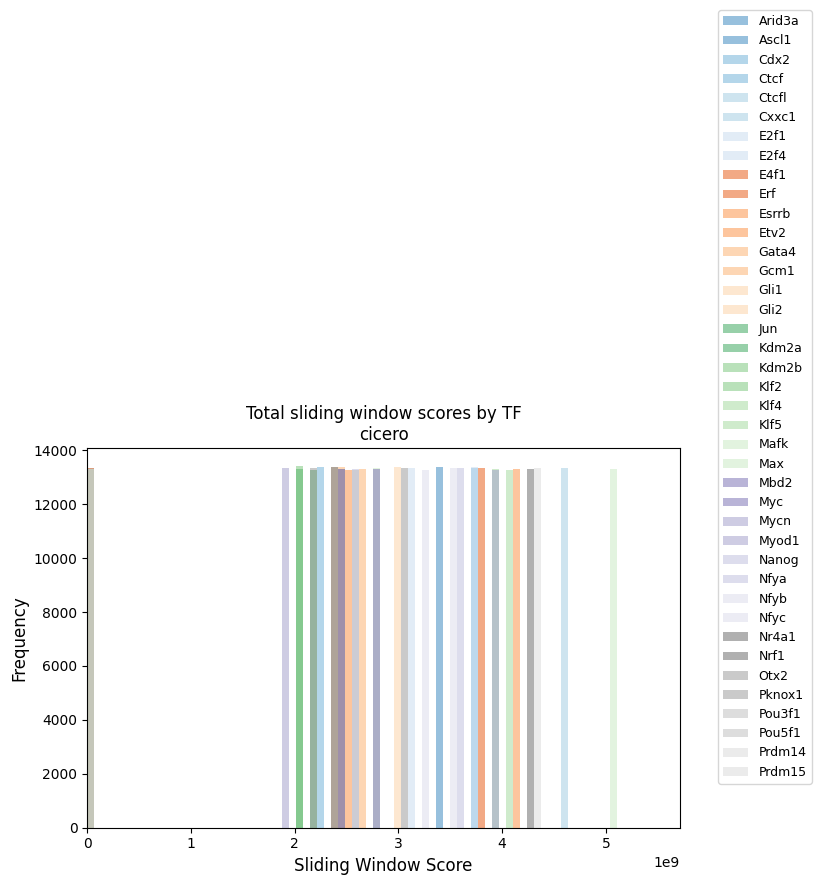

In [ ]:
importlib.reload(dev_plots)

df = (
    ds011_gene_tss_tf_tg_sum_rn111_df
    .groupby("source_id")
    .count()
    .sort_values("total_tf_score", ascending=False)
    .reset_index()
    )
tfs_of_interest = df["source_id"].drop_duplicates().to_list()

num_tfs = 40

dev_plots.plot_score_distribution_by_tf(
    df=ds011_gene_tss_tf_tg_sum_rn111_df, 
    score_col="total_tf_score", 
    title="Total sliding window scores by TF\ncicero",
    top_tf_limit=num_tfs,
    tfs_of_interest=tfs_of_interest
    )

Sum of all sliding window scores for each TF, grouped by TG

Sum of sliding window scores for multiple TF-TG peaks, grouped by TF

INFO: Limiting to scores from the top 15 TFs, found 15


100%|██████████| 15/15 [00:00<00:00, 20.42it/s]                                                                                                                                                                                      


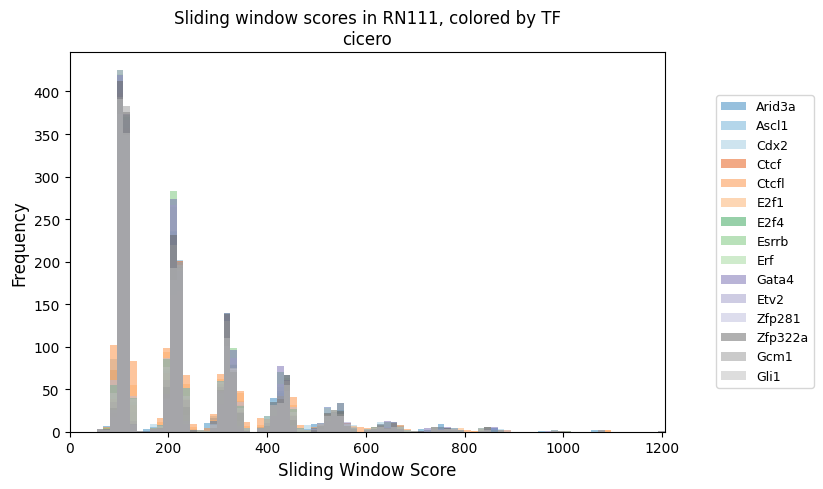

In [ ]:
importlib.reload(dev_plots)

df = (
    ds011_cicero_tf_tg_sum_rn111_df
    .groupby("source_id")
    .count()
    .sort_values("sliding_window_score", ascending=False)
    .reset_index()
    )
tfs_of_interest = df["source_id"].drop_duplicates().to_list()

num_tfs = 15

dev_plots.plot_score_distribution_by_tf(
    df=ds011_cicero_tf_tg_sum_rn111_df, 
    score_col="sliding_window_score", 
    title="Sliding window scores in RN111, colored by TF\ncicero",
    top_tf_limit=num_tfs,
    tfs_of_interest=tfs_of_interest
    )

INFO: Limiting to scores from the top 15 TFs, found 15


100%|██████████| 15/15 [00:00<00:00, 25.73it/s]                                                                                                                                                                                      


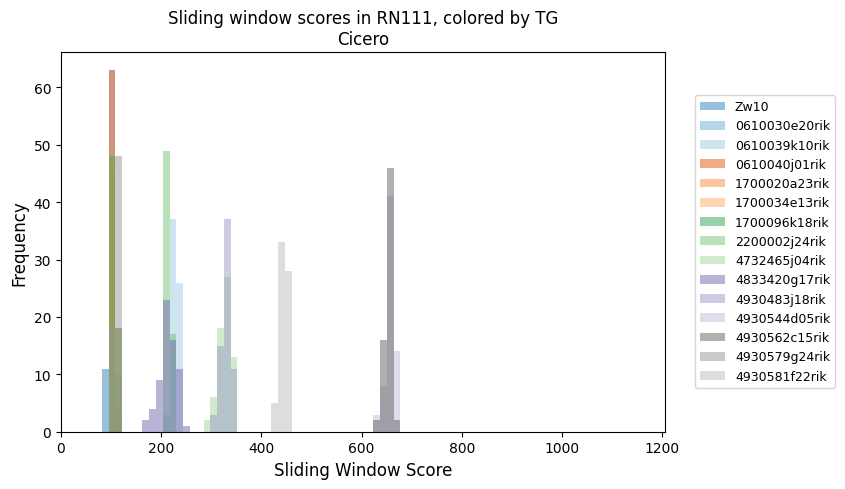

In [ ]:
importlib.reload(dev_plots)

df = (
    ds011_cicero_tf_tg_sum_rn111_df
    .groupby("target_id")
    .count()
    .sort_values("sliding_window_score", ascending=False)
    .reset_index()
    )
tfs_of_interest = df["target_id"].drop_duplicates().to_list()

num_tfs = 15

dev_plots.plot_score_distribution_by_tf(
    df=ds011_cicero_tf_tg_sum_rn111_df, 
    score_col="sliding_window_score", 
    tf_col_name="target_id",
    title="Sliding window scores in RN111, colored by TG\nCicero",
    top_tf_limit=num_tfs,
    tfs_of_interest=tfs_of_interest
    )

It looks like the sliding window scores are mainly grouping by TG rather than TF. We can see how tight the sliding window score distributions are around each TG to get a better sense of what's going on. If the score distributions are tight for individual TGs but the score distributions are different *between* TGs, this would explain the spikey distribution in the sliding window scores.

/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/notebooks/plotting.py:501: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(),fontsize=fontsize-1)


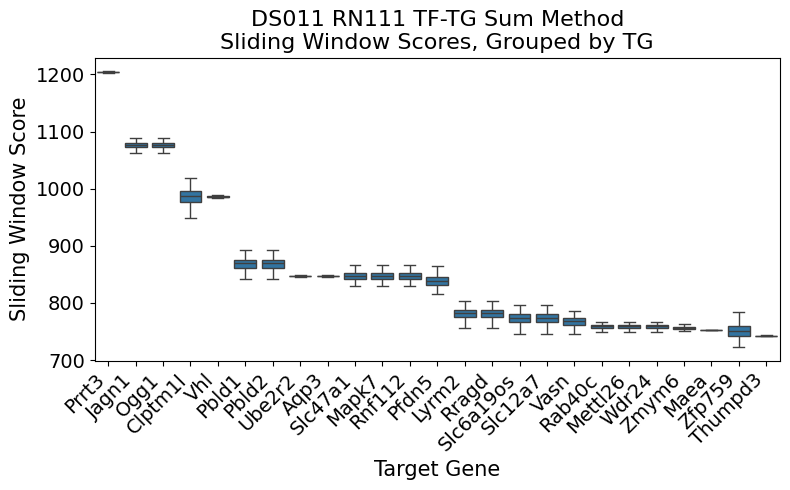

In [ ]:
fig = dev_plots.plot_grouped_score_boxplot(
    df=ds011_cicero_tf_tg_sum_rn111_df,
    group_col="target_id",
    score_col="sliding_window_score",
    title="DS011 RN111 TF-TG Sum Method\nSliding Window Scores, Grouped by TG",
    xlabel="Target Gene",
    ylabel="Sliding Window Score",
    n_top_groups=25,
)
fig.show()

This shows what's going on. The sliding window score distributions are tight for each TG, and different between TGs. This is interesting, it's likely due to the number of sliding window scores per TG. I bet that each discrete level of scores with similar TG distributions represent a different number of peaks. When we add up the sliding window scores across all peaks, TGs with more than one peak will have a greater score.

---

# Checking if the sliding window scores for individual TFs and TGs are different between True / False scores

### Calculating Difference between True / False Score Distribution Means

In [68]:
from scipy import stats

We need to calculate the difference between the True and False sliding window score means for each TF. We will use Welch's t to calculate if the differences are significant.

$$z = \frac{ (\bar{X}_{\text{True}} - \bar{X}_{\text{False}}) }{ \sqrt{ \frac{s_{\text{True}}^{2}}{n_{\text{True}}} + \frac{s_{\text{False}}^{2}}{n_{\text{False}}} }}$$

$$df = \frac{ ( \frac{s^{2}_{\text{True}}}{n_{\text{True}}} + \frac{s^{2}_{\text{False}}}{n_{\text{False}}} )^{2} }{ \frac{ (s^{2}_{\text{True}}/n_{True})^{2} }{n_{\text{True}}-1} + \frac{ (s^{2}_{\text{False}}/n_{\text{False}})^{2} }{n_{\text{False}}-1} }$$

First, we need to log1p normalize the sliding window scores to get them into roughly normal distributions and calculate the mean, std, and count of True / False sliding window scores by TF.

In [69]:
def calculate_difference_between_true_false_scores(df: pd.DataFrame, group_col: str) -> pd.DataFrame:
    # Calculate the mean, stdev, and count of sliding window scores for each TF
    df = df.copy()
    df_grouped = (
        df[["source_id", "target_id", "sliding_window_score", "label"]]
        .groupby([group_col, "label"])
        .agg(
            mean=("sliding_window_score", "mean"),
            stdev=("sliding_window_score", "std"), # Guards against taking the stderr of mean when only 1 score
            count=("sliding_window_score", "size")
            )
        .reset_index()
        .dropna()
    )

    # Separate the scores by label
    pivot_df = pd.pivot(
        data=df_grouped, 
        index=group_col, 
        columns="label", 
        values=["mean", "stdev", "count"],
        ).reset_index()

    # Flatten columns to strings (rather than multi index)
    pivot_df.columns = [
        f"{col1}_{col2}" if col2 != "" else str(col1)
        for col1, col2 in pivot_df.columns
    ]

    # Welch's t
    se_diff = np.sqrt((pivot_df["stdev_True"]**2)/pivot_df["count_True"] + (pivot_df["stdev_False"]**2)/pivot_df["count_False"])
    t_stat = (pivot_df["mean_True"] - pivot_df["mean_False"]) / se_diff

    # Welch-Satterthwaite df
    df_numerator = ((pivot_df["stdev_True"]**2)/pivot_df["count_True"] + (pivot_df["stdev_False"]**2)/pivot_df["count_False"])**2
    df_denominator = ((pivot_df["stdev_True"]**2)/pivot_df["count_True"])**2 / (pivot_df["count_True"]-1) + ((pivot_df["stdev_False"]**2)/pivot_df["count_False"])**2 / (pivot_df["count_False"]-1)

    df = df_numerator / df_denominator

    # two-tailed p-values
    p_val = 2 * stats.t.sf(np.abs(t_stat), df)

    pivot_df["t_stat"] = t_stat
    pivot_df["df"] = df
    pivot_df["p_value"] = p_val
    pivot_df["significant"] = p_val < 0.05

    # Sort by significance
    pivot_df = pivot_df.sort_values(by="p_value", ascending=True)
    
    pivot_df = pivot_df.dropna()
    
    return pivot_df

### mESC True / False score Distribution Difference

In [ ]:
norm_mesc_gene_tss_tf_tg_sum_rn111_df = mesc_gene_tss_tf_tg_sum_rn111_df.copy()
norm_mesc_gene_tss_tf_tg_sum_rn111_df["sliding_window_score"] = np.log1p(mesc_gene_tss_tf_tg_sum_rn111_df["sliding_window_score"])

mesc_tf_mean_diff_df = calculate_difference_between_true_false_scores(norm_mesc_gene_tss_tf_tg_sum_rn111_df, group_col="source_id")
mesc_tg_mean_diff_df = calculate_difference_between_true_false_scores(norm_mesc_gene_tss_tf_tg_sum_rn111_df, group_col="target_id")


#### Plotting differences between True / False Means by TF

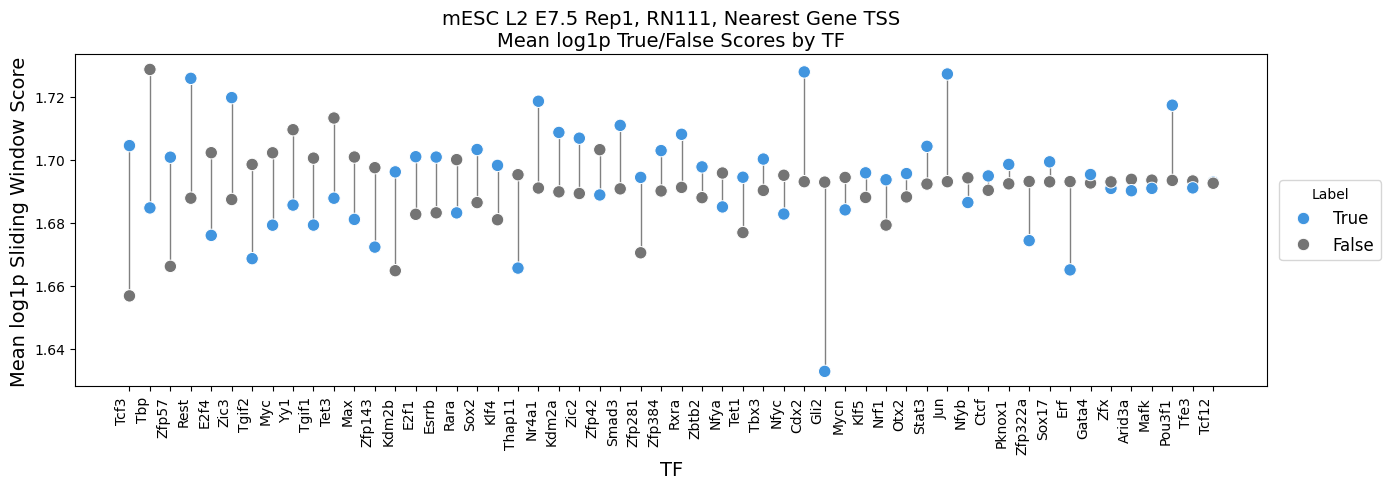

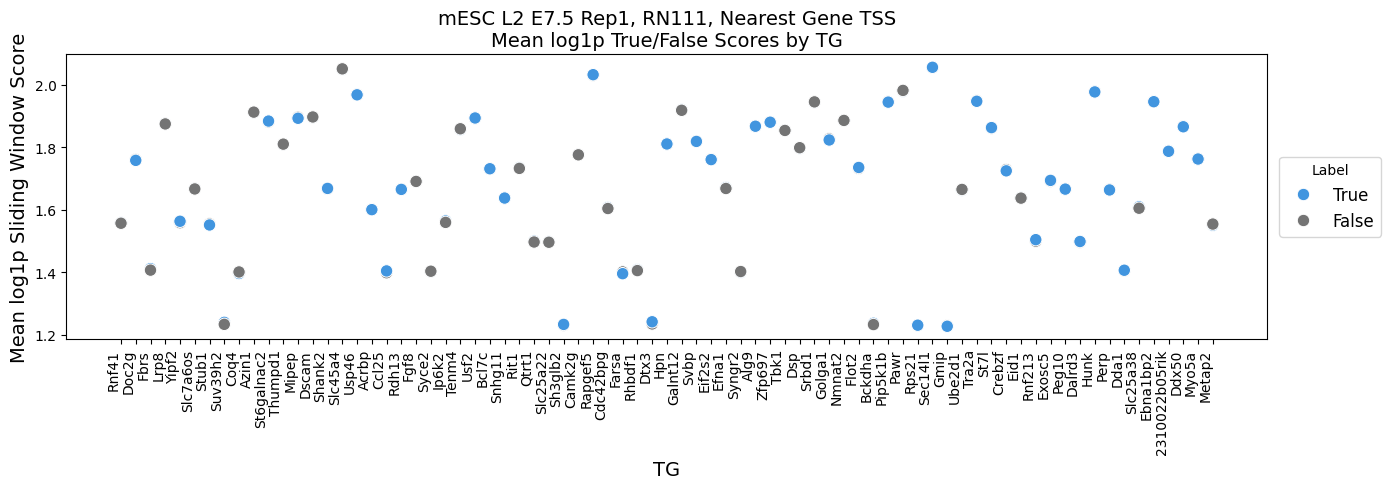

In [ ]:
mesc_tf_fig = dev_plots.plot_mean_score_differences_grouped(
    df=mesc_tf_mean_diff_df, 
    group_col="source_id",
    sample_name="mESC L2 E7.5 Rep1",
    ground_truth_name="RN111",
    tg_label_name="Nearest Gene TSS"
    )
mesc_tf_fig.show()

mesc_tg_fig = dev_plots.plot_mean_score_differences_grouped(
    df=mesc_tg_mean_diff_df, 
    group_col="target_id",
    sample_name="mESC L2 E7.5 Rep1",
    ground_truth_name="RN111",
    tg_label_name="Nearest Gene TSS",
    )
mces_tg_fig.show()

#### Plotting True / False Score Distributions by TF and TG

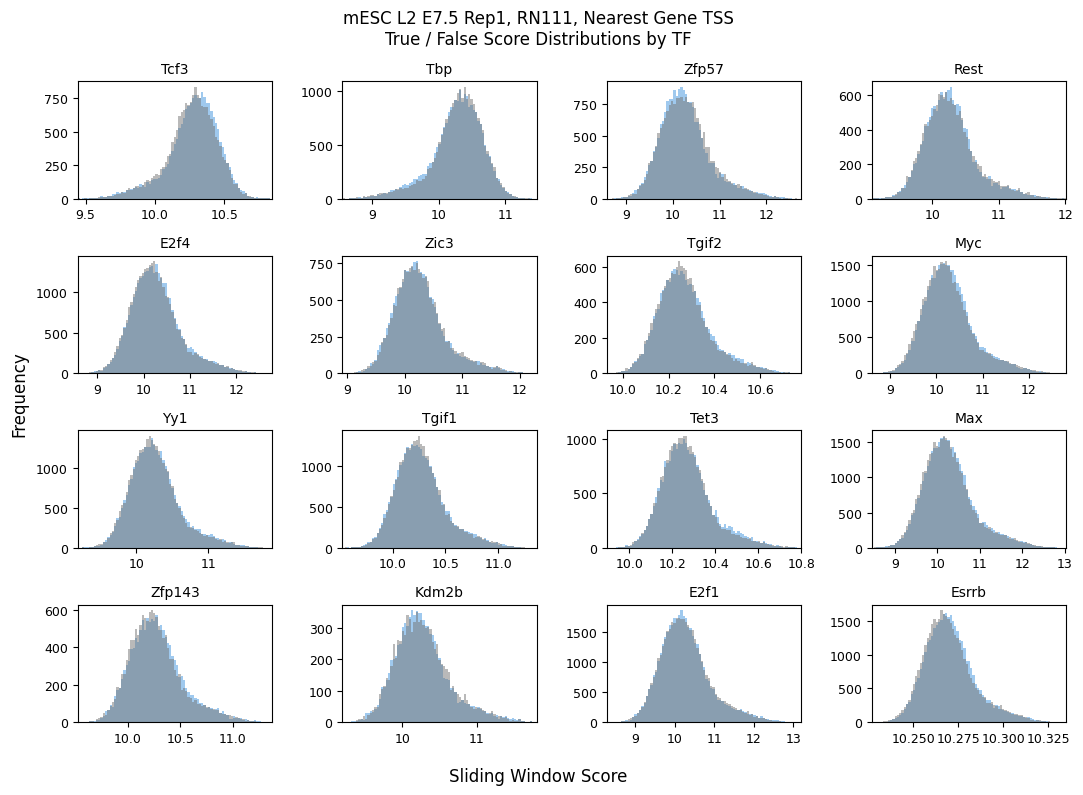

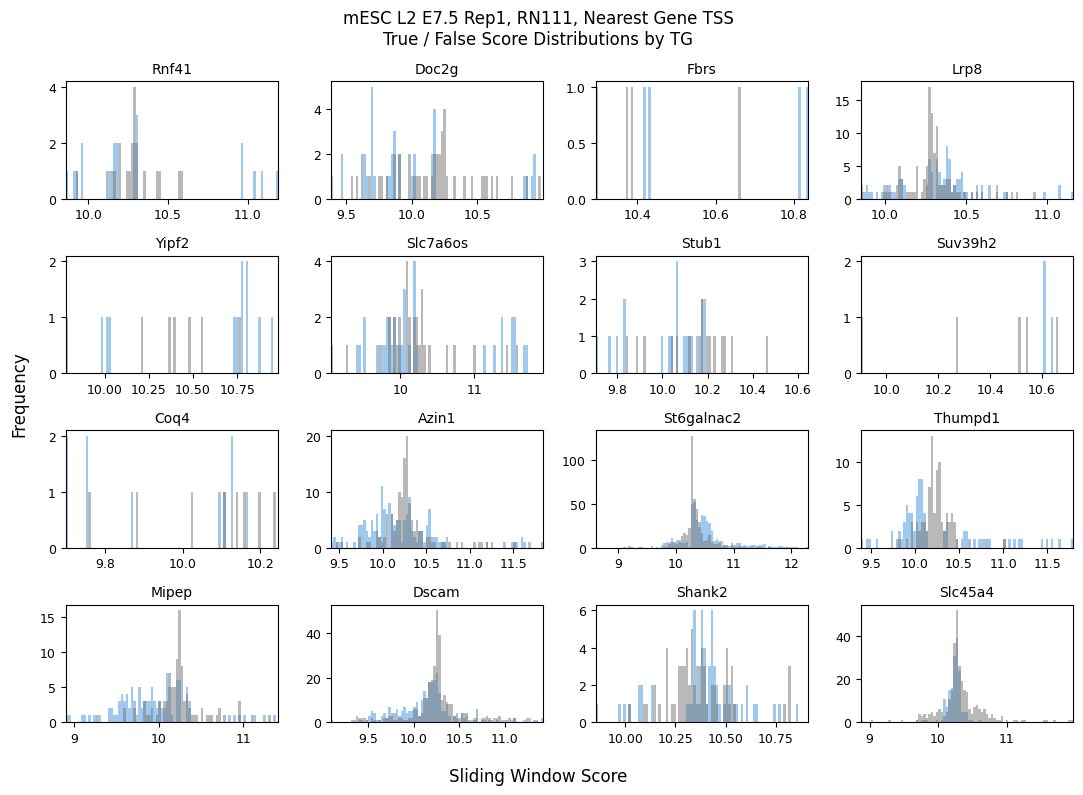

In [ ]:
tf_fig = dev_plots.plot_individual_true_false_distributions(
    mean_diff_df=mesc_tf_mean_diff_df, 
    original_score_df=mesc_gene_tss_tf_peak_tg_rn111_df,
    group_col="source_id",
    sample_name="mESC L2 E7.5 Rep1",
    ground_truth_name="RN111",
    tg_label_name="Nearest Gene TSS"
    )
tf_fig.show()

tg_fig = dev_plots.plot_individual_true_false_distributions(
    mean_diff_df=mesc_tg_mean_diff_df, 
    original_score_df=mesc_gene_tss_tf_peak_tg_rn111_df,
    group_col="target_id",
    sample_name="mESC L2 E7.5 Rep1",
    ground_truth_name="RN111",
    tg_label_name="Nearest Gene TSS"
    )
tg_fig.show()

#### Plotting Sliding Window Score vs Number of Peaks per TG

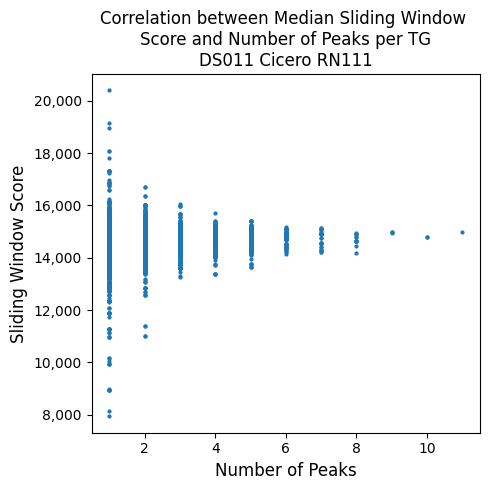

In [ ]:
import matplotlib.ticker


edges_per_tg = (
    ds011_cicero_sliding_window_df
    .groupby("target_id")
    .agg(
        peak_count=("peak_id", "nunique"),
        median_score=("sliding_window_score", "median")
    )
    .reset_index()
    .sort_values(by="peak_count", ascending=False)
)

correlation = np.corrcoef(edges_per_tg["peak_count"], edges_per_tg["median_score"])

plt.figure(figsize=(5,5))
plt.scatter(x=edges_per_tg["peak_count"], y=edges_per_tg["median_score"], s=4),
plt.title("Correlation between Median Sliding Window \nScore and Number of Peaks per TG\nDS011 Cicero RN111", fontsize=12)
plt.xlabel("Number of Peaks", fontsize=12)
plt.ylabel("Sliding Window Score", fontsize=12)

plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.tight_layout()
plt.show()

### ChIP-seq True / False Score Distribution Difference

In [90]:
norm_df = chipseq_gene_tss_tf_peak_tg_rn111_df.copy()
norm_df["sliding_window_score"] = np.log1p(norm_df["sliding_window_score"])

chipseq_tf_mean_diff_df = calculate_difference_between_true_false_scores(norm_df, group_col="source_id")

chipseq_tg_mean_diff_df = calculate_difference_between_true_false_scores(norm_df, group_col="target_id")

#### Plotting differences between True / False Means by TF

In [ ]:
chipseq_tf_fig = dev_plots.plot_mean_score_differences_grouped(
    df=chipseq_tf_mean_diff_df, 
    group_col="source_id",
    sample_name="ChIP-seq",
    ground_truth_name="RN111",
    tg_label_name="Nearest Gene TSS"
    )
chipseq_tf_fig.show()

chipseq_tg_fig = dev_plots.plot_mean_score_differences_grouped(
    df=chipseq_tg_mean_diff_df, 
    group_col="target_id",
    sample_name="ChIP-seq",
    ground_truth_name="RN111",
    tg_label_name="Nearest Gene TSS",
    )
chipseq_tg_fig.show()

#### Plotting True / False Score Distributions by TF and TG

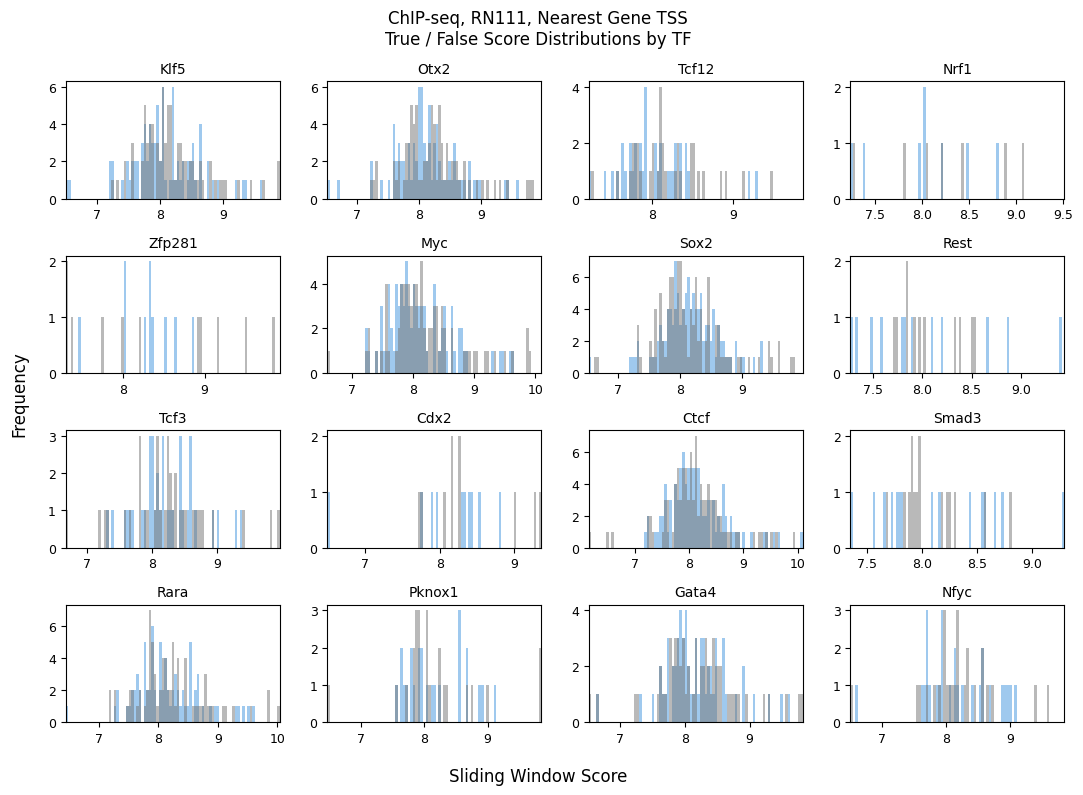

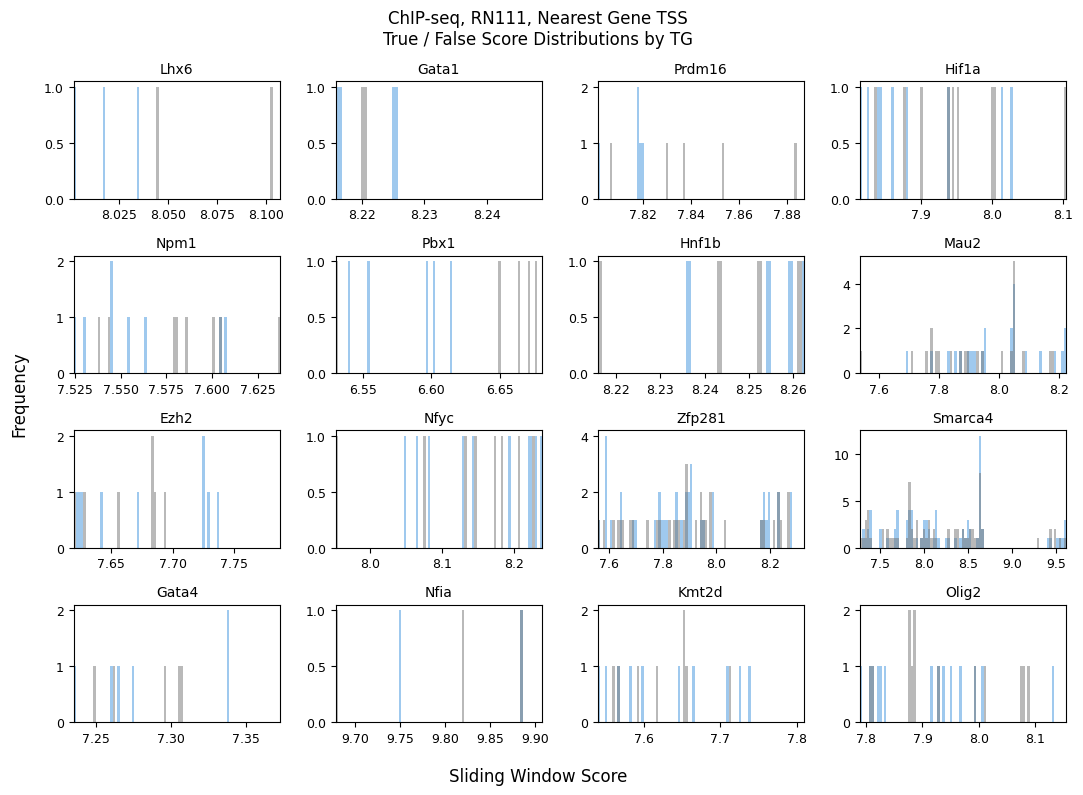

In [91]:
tf_fig = dev_plots.plot_individual_true_false_distributions(
    mean_diff_df=chipseq_tf_mean_diff_df, 
    original_score_df=norm_df,
    group_col="source_id",
    sample_name="ChIP-seq",
    ground_truth_name="RN111",
    tg_label_name="Nearest Gene TSS"
    )
tf_fig.show()

tg_fig = dev_plots.plot_individual_true_false_distributions(
    mean_diff_df=chipseq_tg_mean_diff_df, 
    original_score_df=norm_df,
    group_col="target_id",
    sample_name="ChIP-seq",
    ground_truth_name="RN111",
    tg_label_name="Nearest Gene TSS"
    )
tg_fig.show()

#### Plotting AUROC Curves for Individual TFs and TGs

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
import warnings

def auc_by_group(df, 
    group_col="source_id", 
    score_col="sliding_window_score",        
    label_col="label", 
    min_pos=5, 
    min_neg=5, 
    bootstrap=None, 
    random_state=0,
    ):
    df = df.copy().dropna()
    rows = []
    rng = np.random.default_rng(random_state)

    for g, sub in df.groupby(group_col, observed=True):
        y = sub[label_col].astype(bool).to_numpy()
        s = sub[score_col].to_numpy()

        n_pos, n_neg = int(y.sum()), int((~y).sum())
        # skip if one class or too few samples
        if (n_pos < min_pos) or (n_neg < min_neg):
            rows.append({group_col: g, "auc": np.nan, "auc_lo": np.nan, "auc_hi": np.nan,
                         "n": len(sub), "n_pos": n_pos, "n_neg": n_neg})
            continue

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")  # silence UndefinedMetricWarning inside loop
            auc = roc_auc_score(y, s)

        lo = hi = np.nan
        if bootstrap:
            idx = rng.integers(0, len(sub), size=(bootstrap, len(sub)))
            auc_bs = np.empty(bootstrap)
            for i in range(bootstrap):
                yi, si = y[idx[i]], s[idx[i]]
                # guard bootstrap resamples that collapse to one class
                if (yi.sum() == 0) or (yi.sum() == len(yi)):
                    auc_bs[i] = np.nan
                else:
                    auc_bs[i] = roc_auc_score(yi, si)
            auc_bs = auc_bs[~np.isnan(auc_bs)]
            if auc_bs.size:
                lo, hi = np.percentile(auc_bs, [2.5, 97.5])

        rows.append({group_col: g, "auc": auc, "auc_lo": lo, "auc_hi": hi,
                     "n": len(sub), "n_pos": n_pos, "n_neg": n_neg})

    return pd.DataFrame(rows)

mesc_gene_tss_tf_tg_sum_rn111_tf_auc_df = auc_by_group(mesc_gene_tss_tf_tg_sum_rn111_df, group_col="source_id", bootstrap=1000)
# mesc_gene_tss_tf_tg_sum_rn111_tg_auc_df = auc_by_group(mesc_gene_tss_tf_tg_sum_rn111_df, group_col="target_id", bootstrap=1000)

# ds011_gene_tss_tf_tg_sum_rn111_tf_auc_df = auc_by_group(mesc_gene_tss_tf_tg_sum_rn111_df, group_col="source_id", bootstrap=1000)
# ds011_gene_tss_tf_tg_sum_rn111_tg_auc_df = auc_by_group(mesc_gene_tss_tf_tg_sum_rn111_df, group_col="target_id", bootstrap=1000)



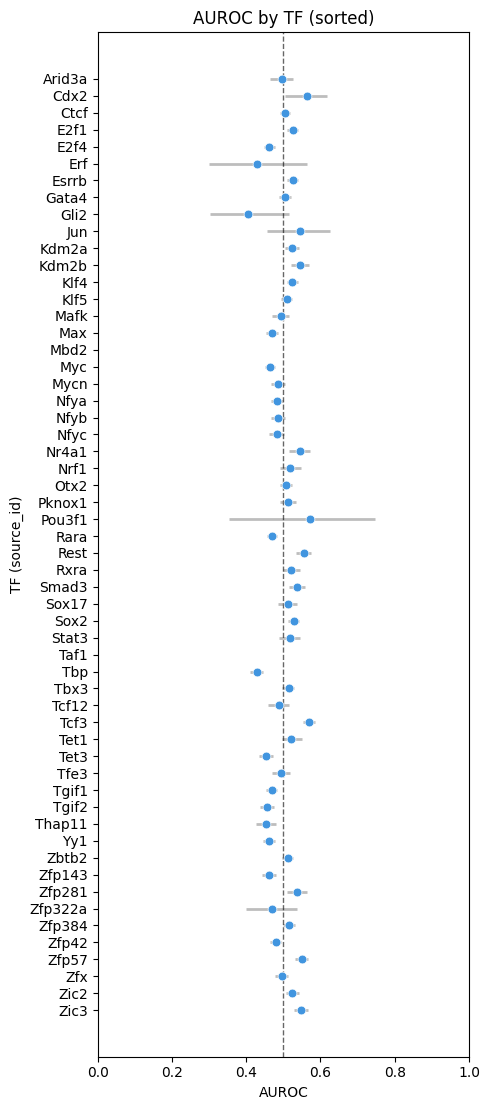

In [192]:
import matplotlib.pyplot as plt
import seaborn as sns

plot_df = auc_df.copy()
plot_df["source_id"] = pd.Categorical(plot_df["source_id"],
                                      categories=plot_df["source_id"],
                                      ordered=True)

fig, ax = plt.subplots(figsize=(5, max(6, 0.20*len(plot_df))))
# points
sns.scatterplot(
    data=plot_df,
    x="auc", y="source_id",
    color="#4195df", s=40, ax=ax, zorder=3
)

# optional 95% CI whiskers from bootstrap
has_ci = plot_df["auc_lo"].notna() & plot_df["auc_hi"].notna()
ax.hlines(
    y=plot_df.loc[has_ci, "source_id"],
    xmin=plot_df.loc[has_ci, "auc_lo"],
    xmax=plot_df.loc[has_ci, "auc_hi"],
    color="#bdbdbd", linewidth=2, zorder=2
)

# baseline @ 0.5
ax.axvline(0.5, ls="--", lw=1, color="k", alpha=0.6)

ax.set_xlabel("AUROC")
ax.set_ylabel("TF (source_id)")
ax.set_title("AUROC by TF (sorted)")
ax.set_xlim(0.0, 1.0)
fig.tight_layout()
plt.show()

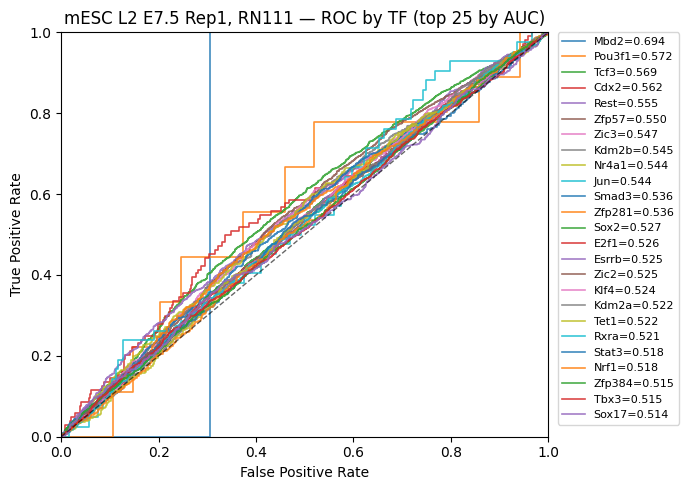

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_by_group(
    df: pd.DataFrame,
    group_col: str = "source_id",
    score_col: str = "sliding_window_score",
    label_col: str = "label",
    top_n: Union[int, None] = 20,          # None = plot all curves (can be very busy)
    min_pos: int = 1,
    min_neg: int = 1,
    sample_name: str="",
    ground_truth_name: str="",
    tg_label_name: str=""
    ):
    
    if group_col == "source_id":
        group_name = "TF"
    elif group_col == "target_id":
        group_name = "TG"
    else:
        group_name = group_col

    curves = []  # (group, fpr, tpr, auc)

    df = df.copy().dropna()
    
    # compute ROC per group, skip groups without both classes
    for g, sub in df.groupby(group_col, observed=True):
        y = sub[label_col].astype(bool).to_numpy()
        s = sub[score_col].to_numpy()
        n_pos, n_neg = int(y.sum()), int((~y).sum())
        if n_pos < min_pos or n_neg < min_neg:
            continue

        fpr, tpr, _ = roc_curve(y, s)     # thresholds unused for plotting
        auc = roc_auc_score(y, s)
        curves.append((g, fpr, tpr, auc, n_pos, n_neg))

    if not curves:
        raise ValueError("No groups had both classes; cannot plot ROC curves.")

    # pick top-N by AUC if requested
    curves.sort(key=lambda x: x[3], reverse=True)
    if top_n is not None:
        curves = curves[:top_n]

    # plot
    fig, ax = plt.subplots(figsize=(7, 5))
    for g, fpr, tpr, auc, n_pos, n_neg in curves:
        ax.plot(fpr, tpr, lw=1.2, alpha=0.85, label=f"{g}={auc:.3f}")

    # baseline
    ax.plot([0, 1], [0, 1], "k--", lw=1, alpha=0.6)

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"{sample_name}, {ground_truth_name}, {tg_label_name}\nAUROC by TF {group_name}")
    ax.legend(bbox_to_anchor=(1.02, 1), ncols=1, loc="upper left", borderaxespad=0., fontsize=8)
    fig.tight_layout()
    return fig

fig = plot_roc_by_group(mesc_gene_tss_tf_tg_sum_rn111_df,
                        group_col="source_id",
                        score_col="sliding_window_score",
                        label_col="label",
                        top_n=25,
                        sample_name="mESC L2 E7.5 Rep1",
                        ground_truth_name="RN111",
                        tg_label_name="Nearest Gene TSS"
                        )
fig.show()
